In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna

# Reading the data

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv", index_col='id')
train.head()

brand              model  model_year  milage      fuel_type  \
id                                                                        
0            MINI      Cooper S Base        2007  213000       Gasoline   
1         Lincoln              LS V8        2002  143250       Gasoline   
2       Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3         Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                               engine  \
id                                                      
0        172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1        252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2   320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3        420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4        208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                      transmission ext_col int_col  \
id                                                   
0                              A/T  Yellow    Gray   
1                              A/T  Silver   Beige   
2                              A/T    Blue    Gray   
3   Transmission w/Dual Shift Mode   Black   Black   
4                      7-Speed A/T   Black   Beige   

                                  accident clean_title  price  
id                                                             
0                            None reported         Yes   4200  
1   At least 1 accident or damage reported         Yes   4999  
2                            None reported         Yes  13900  
3                            None reported         Yes  45000  
4                            None reported         Yes  97500

In [4]:
len(train)

188533

# Exploratory Data Analysis and data management

In [5]:
obj_cols = []
int_cols = []
for col in train.columns:
    print(train[col].dtypes)
    if train[col].dtypes=='object':
        obj_cols.append(col)
    elif train[col].dtypes=='int64':
        int_cols.append(col)
    else:
        print(f"{col} - Some other datatype!")
        
int_cols.remove('price')
print(int_cols)
print(obj_cols)

object
object
int64
int64
object
object
object
object
object
object
object
int64
['model_year', 'milage']
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [6]:
print("The number of NULL values in each columns....")
for col in train.columns:
    print(f"{col} --- > {train[col].isna().sum()}")
    print(f"In percentage ---- > **{(train[col].isna().sum()/len(train))*100:.2f} %**")

The number of NULL values in each columns....
brand --- > 0
In percentage ---- > **0.00 %**
model --- > 0
In percentage ---- > **0.00 %**
model_year --- > 0
In percentage ---- > **0.00 %**
milage --- > 0
In percentage ---- > **0.00 %**
fuel_type --- > 5083
In percentage ---- > **2.70 %**
engine --- > 0
In percentage ---- > **0.00 %**
transmission --- > 0
In percentage ---- > **0.00 %**
ext_col --- > 0
In percentage ---- > **0.00 %**
int_col --- > 0
In percentage ---- > **0.00 %**
accident --- > 2452
In percentage ---- > **1.30 %**
clean_title --- > 21419
In percentage ---- > **11.36 %**
price --- > 0
In percentage ---- > **0.00 %**


Number of Unique Values in Object Columns...
brand ----> 57
model ----> 1897
fuel_type ----> 7
engine ----> 1117
transmission ----> 52
ext_col ----> 319
int_col ----> 156
accident ----> 2
clean_title ----> 1


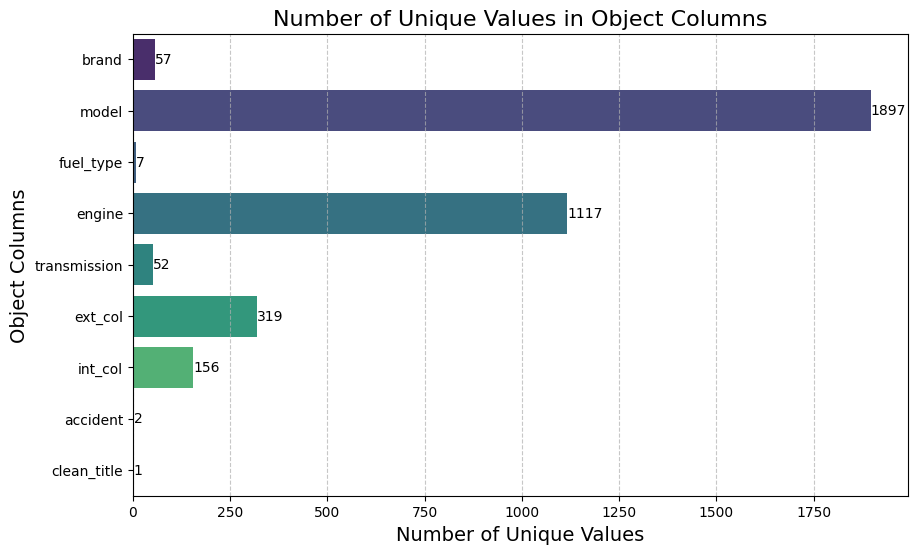

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Number of Unique Values in Object Columns...")
uniques = {}
for col in obj_cols:
    print(f"{col} ----> {train[col].nunique()}")
    uniques[col] = train[col].nunique()

plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
sns.barplot(y=list(uniques.keys()), x=list(uniques.values()), palette="viridis")

plt.title("Number of Unique Values in Object Columns", fontsize=16)
plt.xlabel("Number of Unique Values", fontsize=14)
plt.ylabel("Object Columns", fontsize=14)

# Annotation
for index, value in enumerate(uniques.values()):
    plt.text(value, index, str(value), color='black', ha="left", va="center")

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

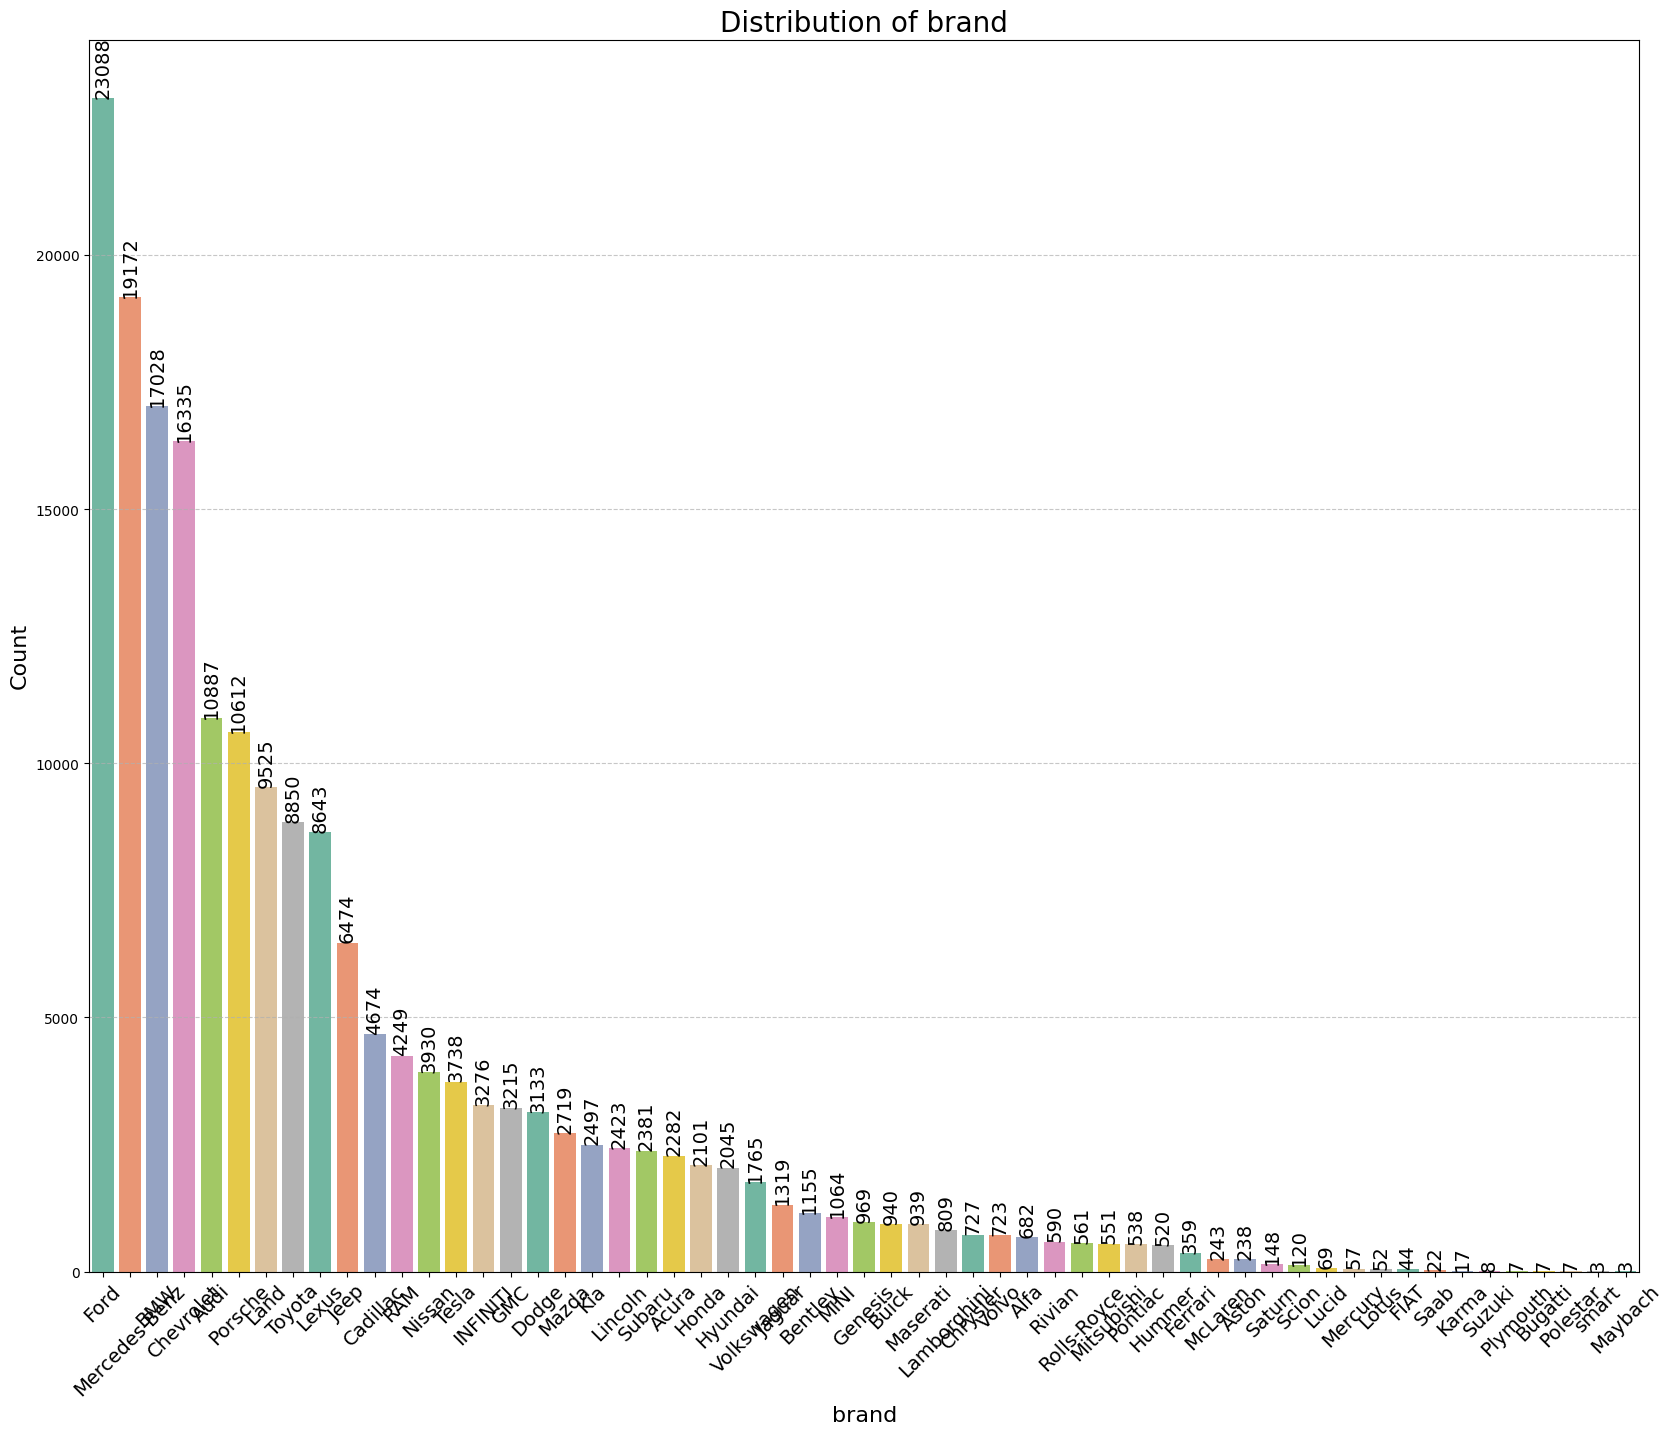

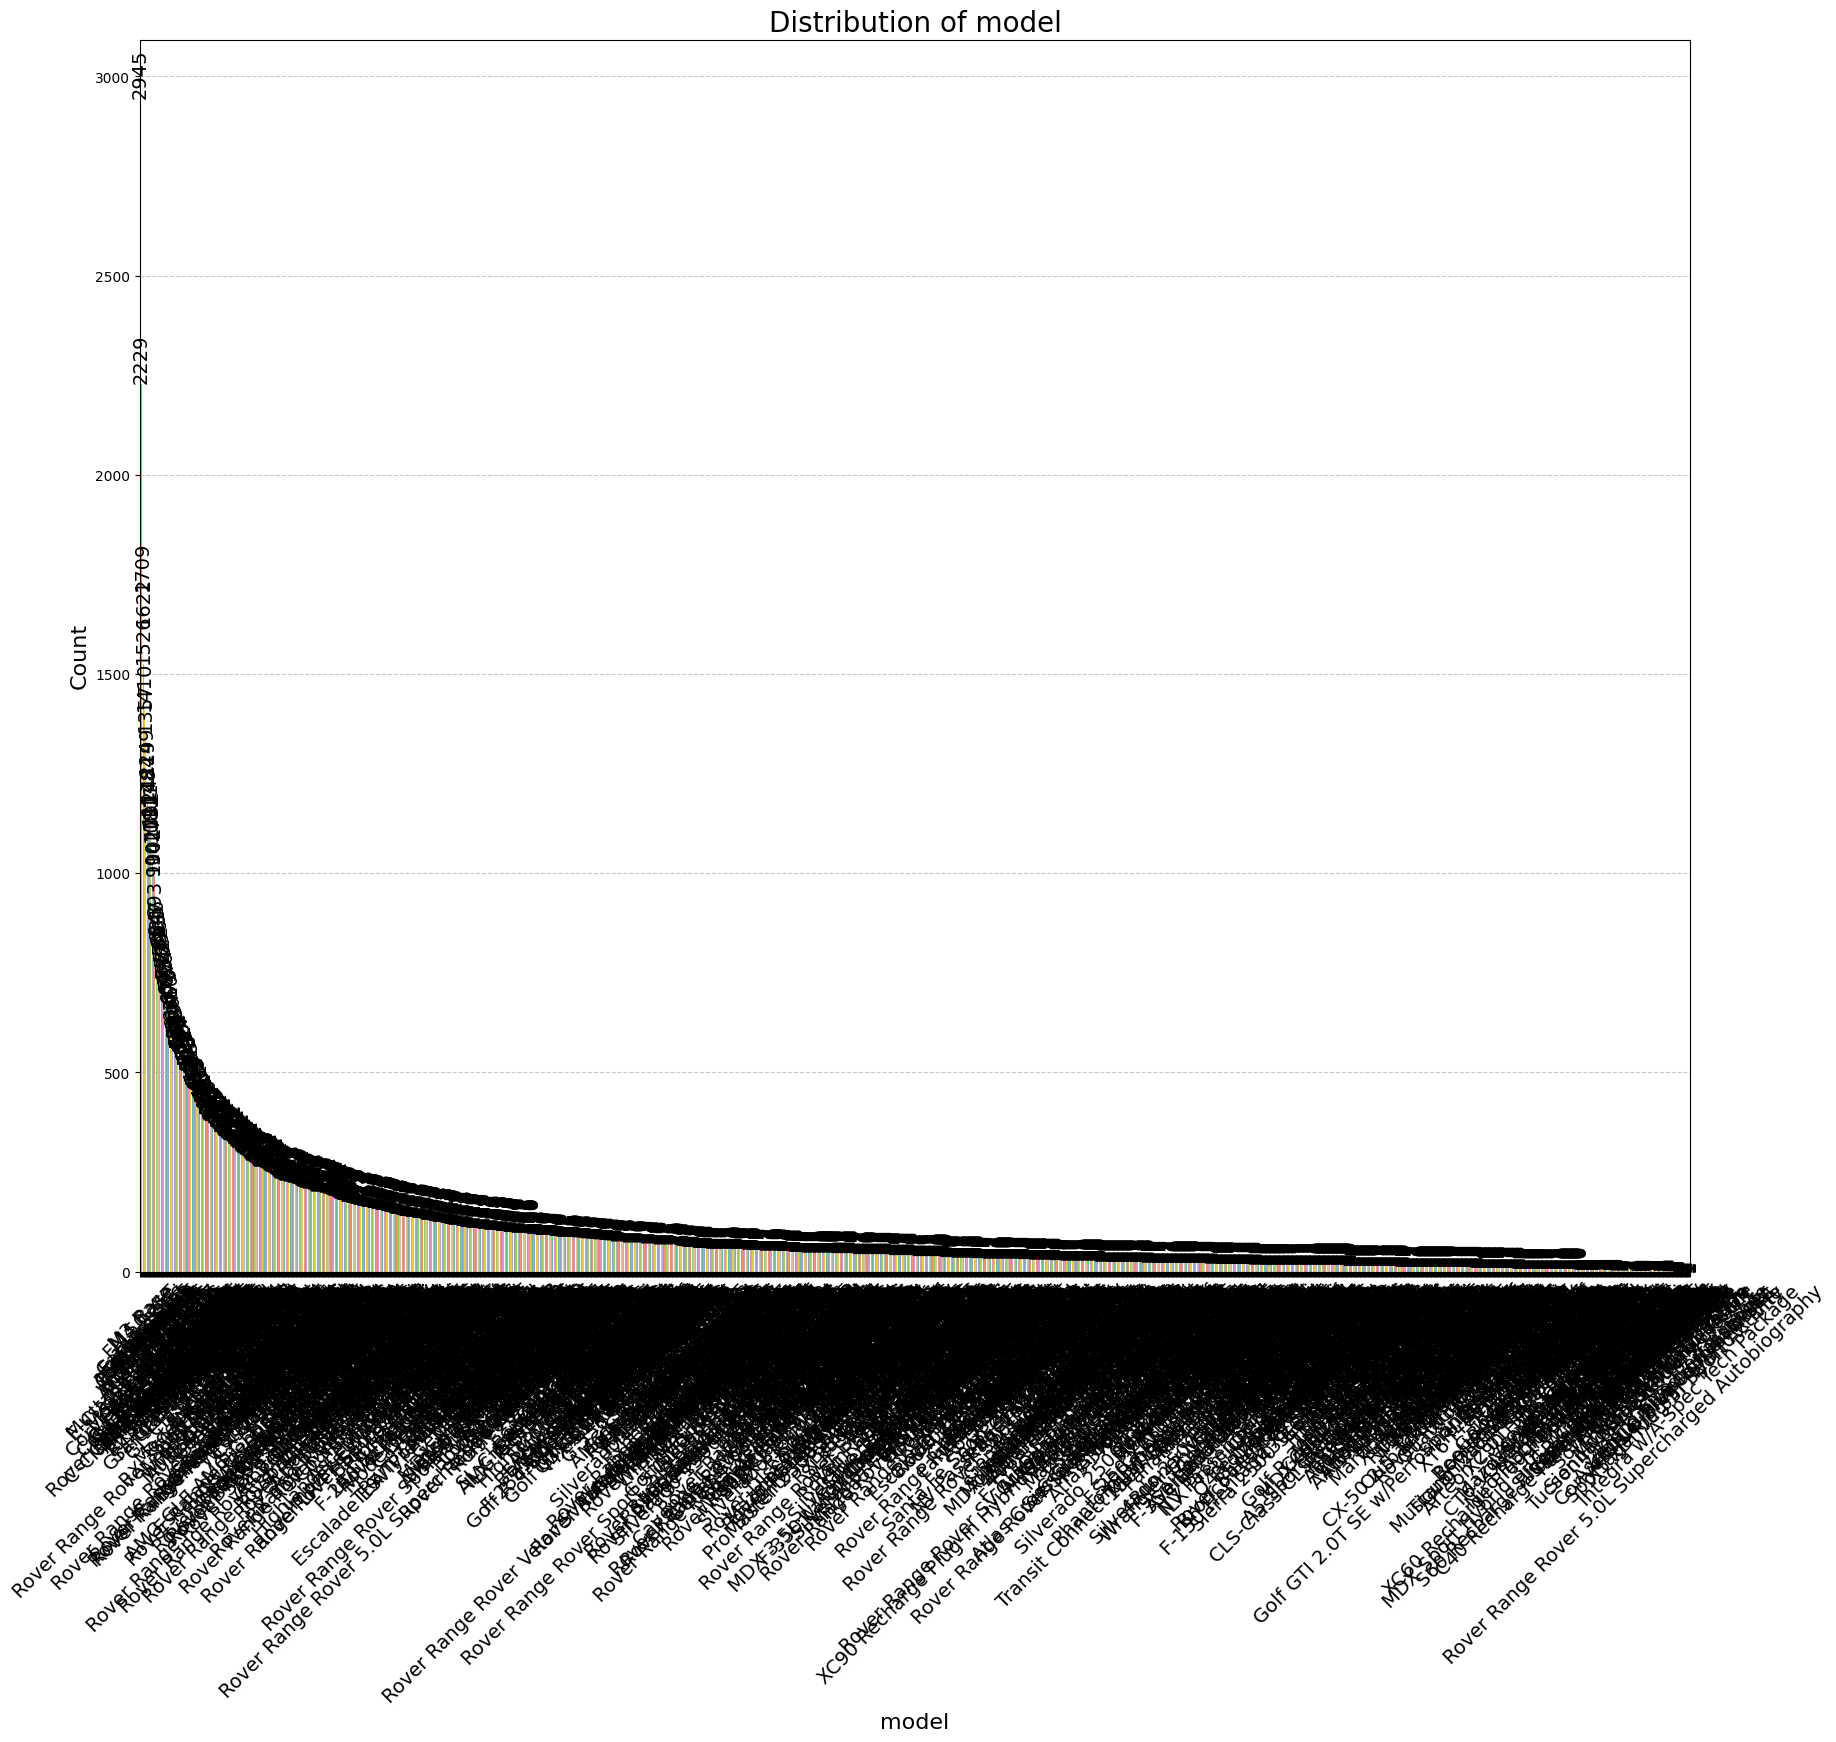

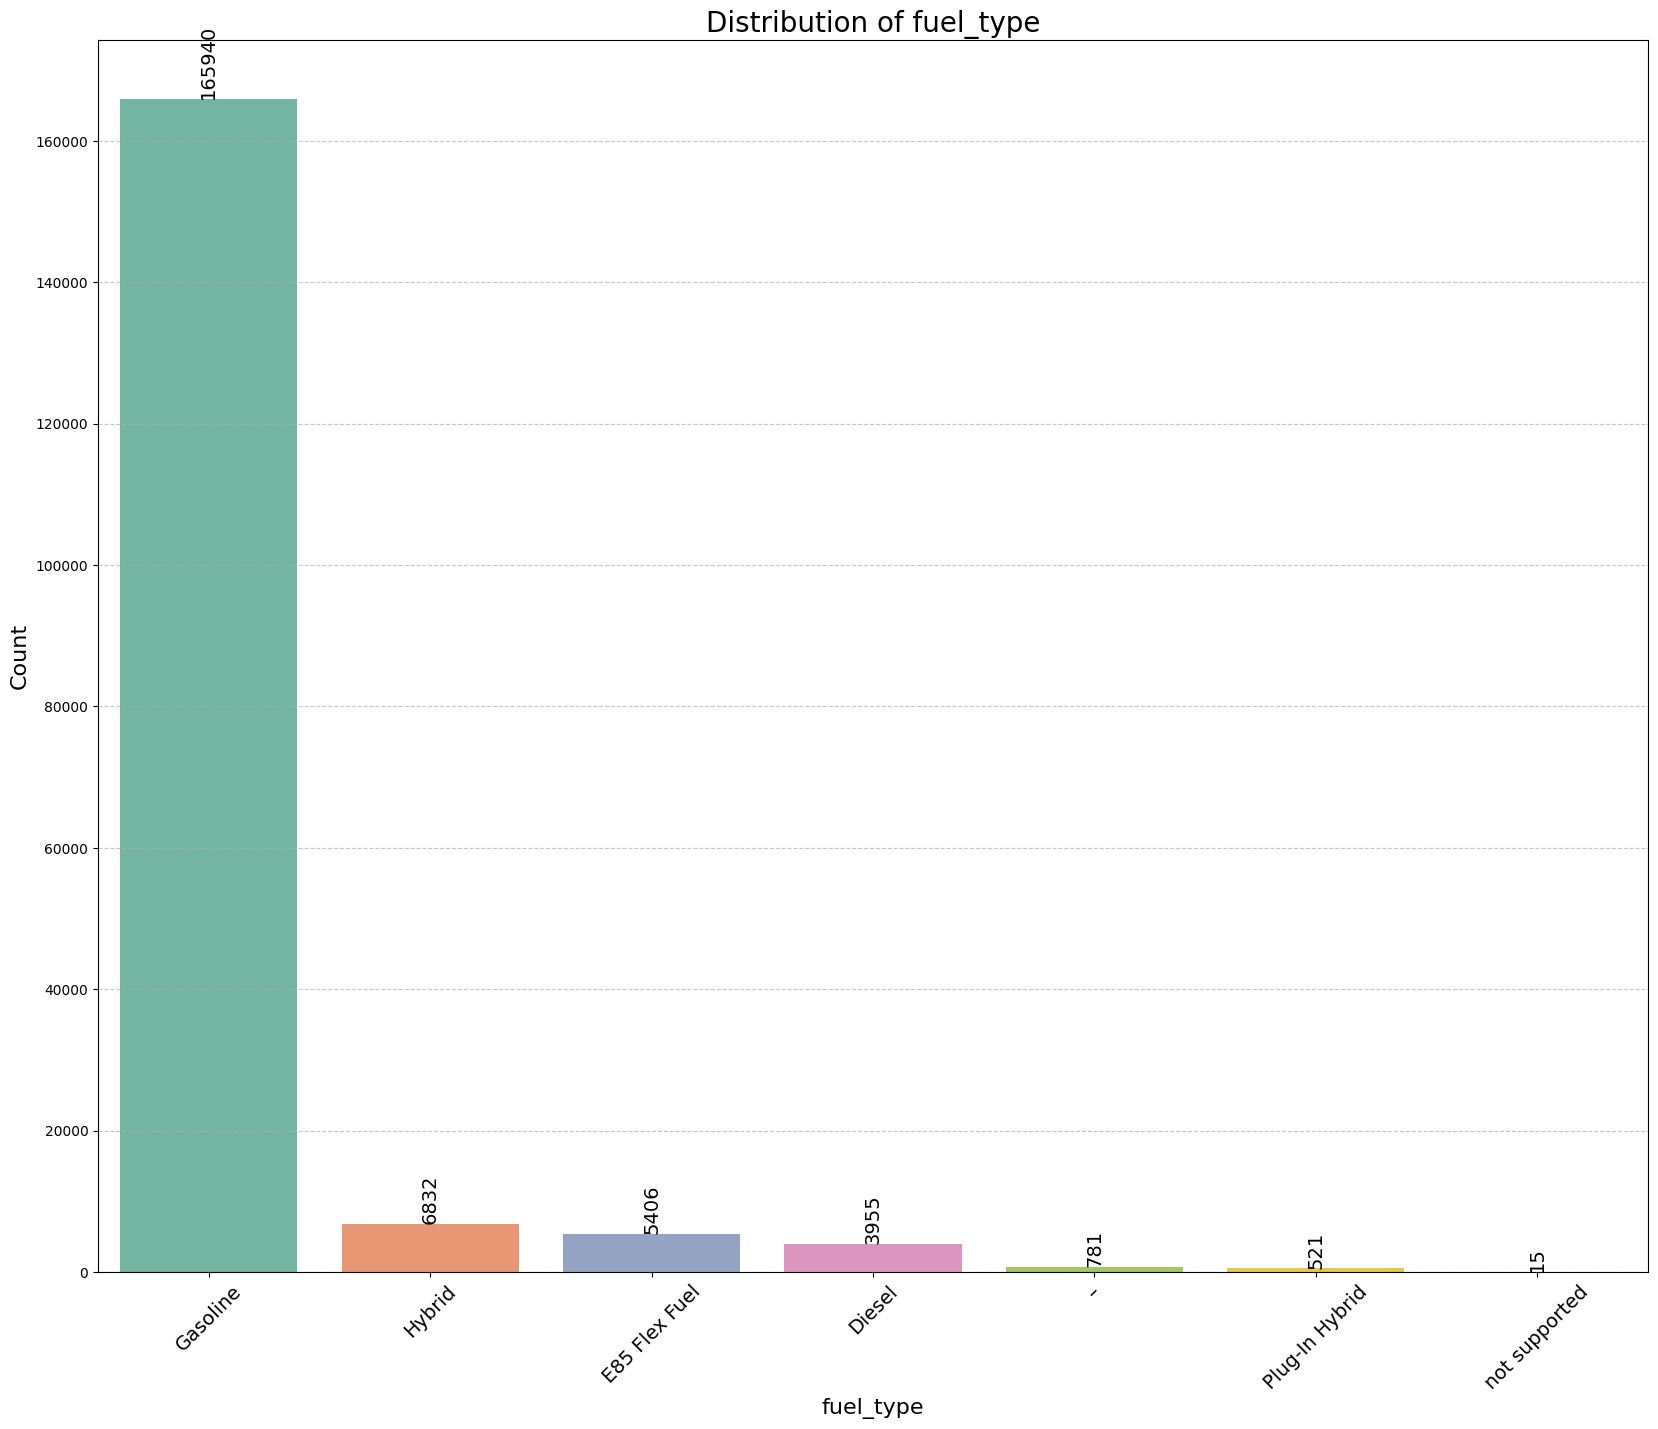

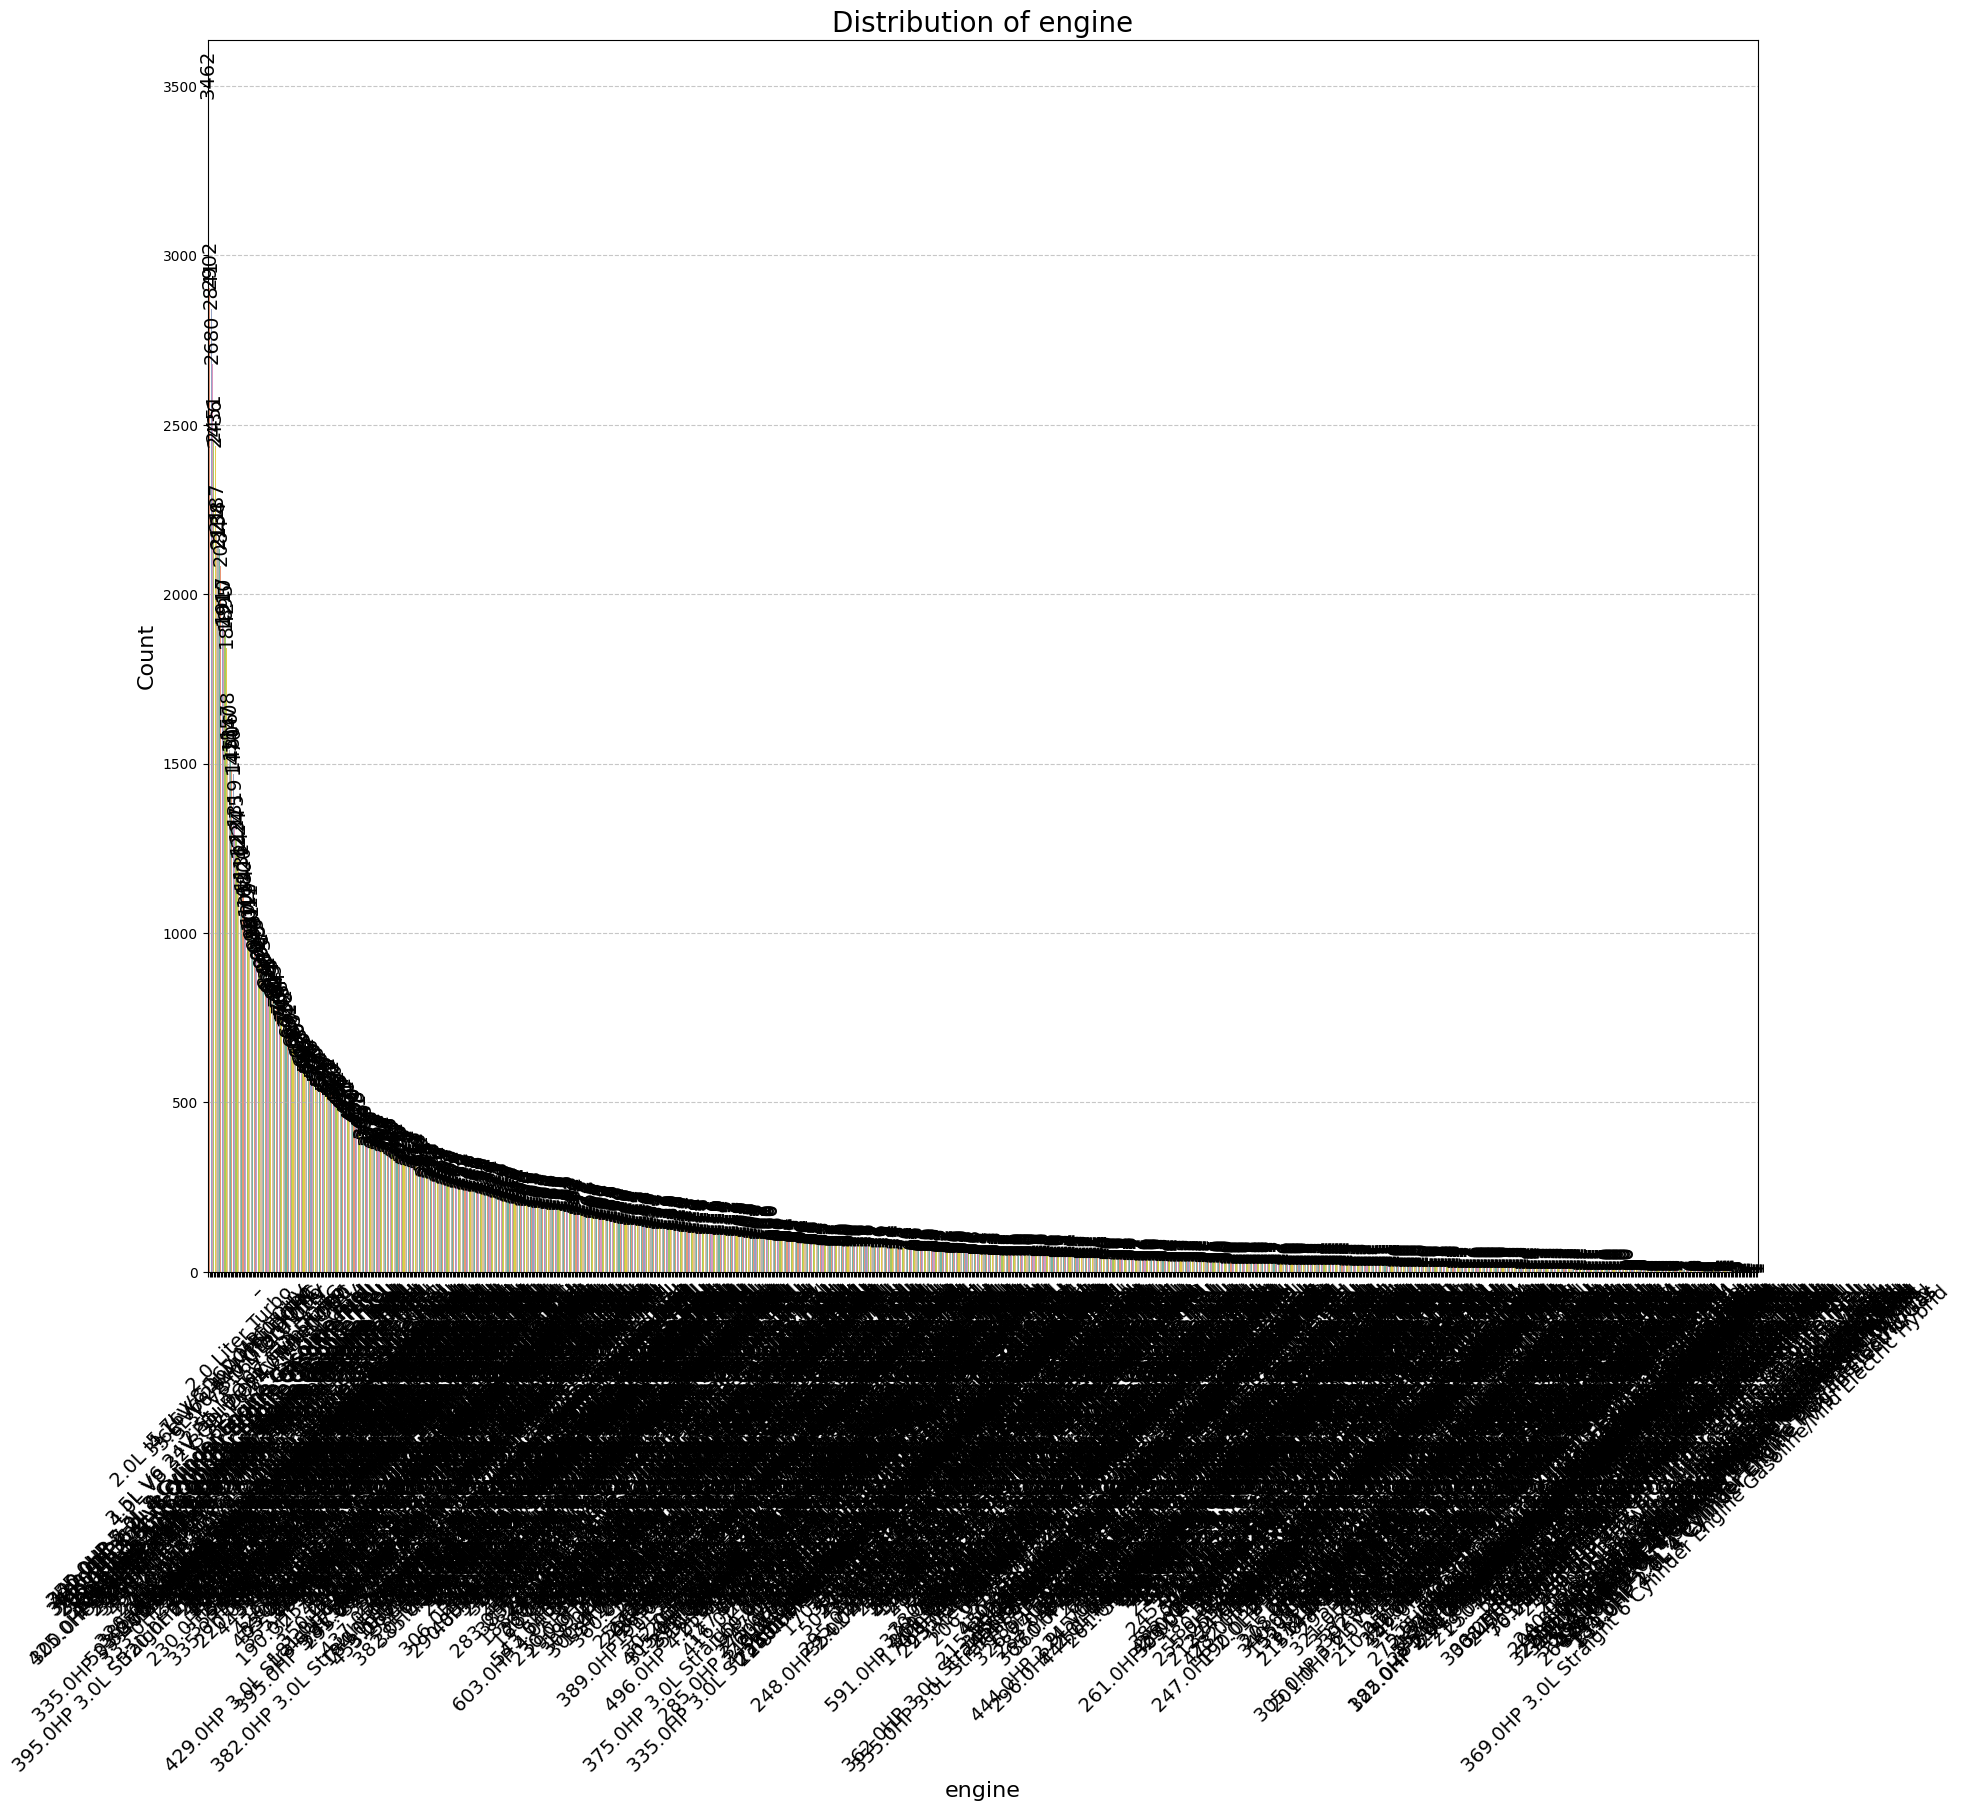

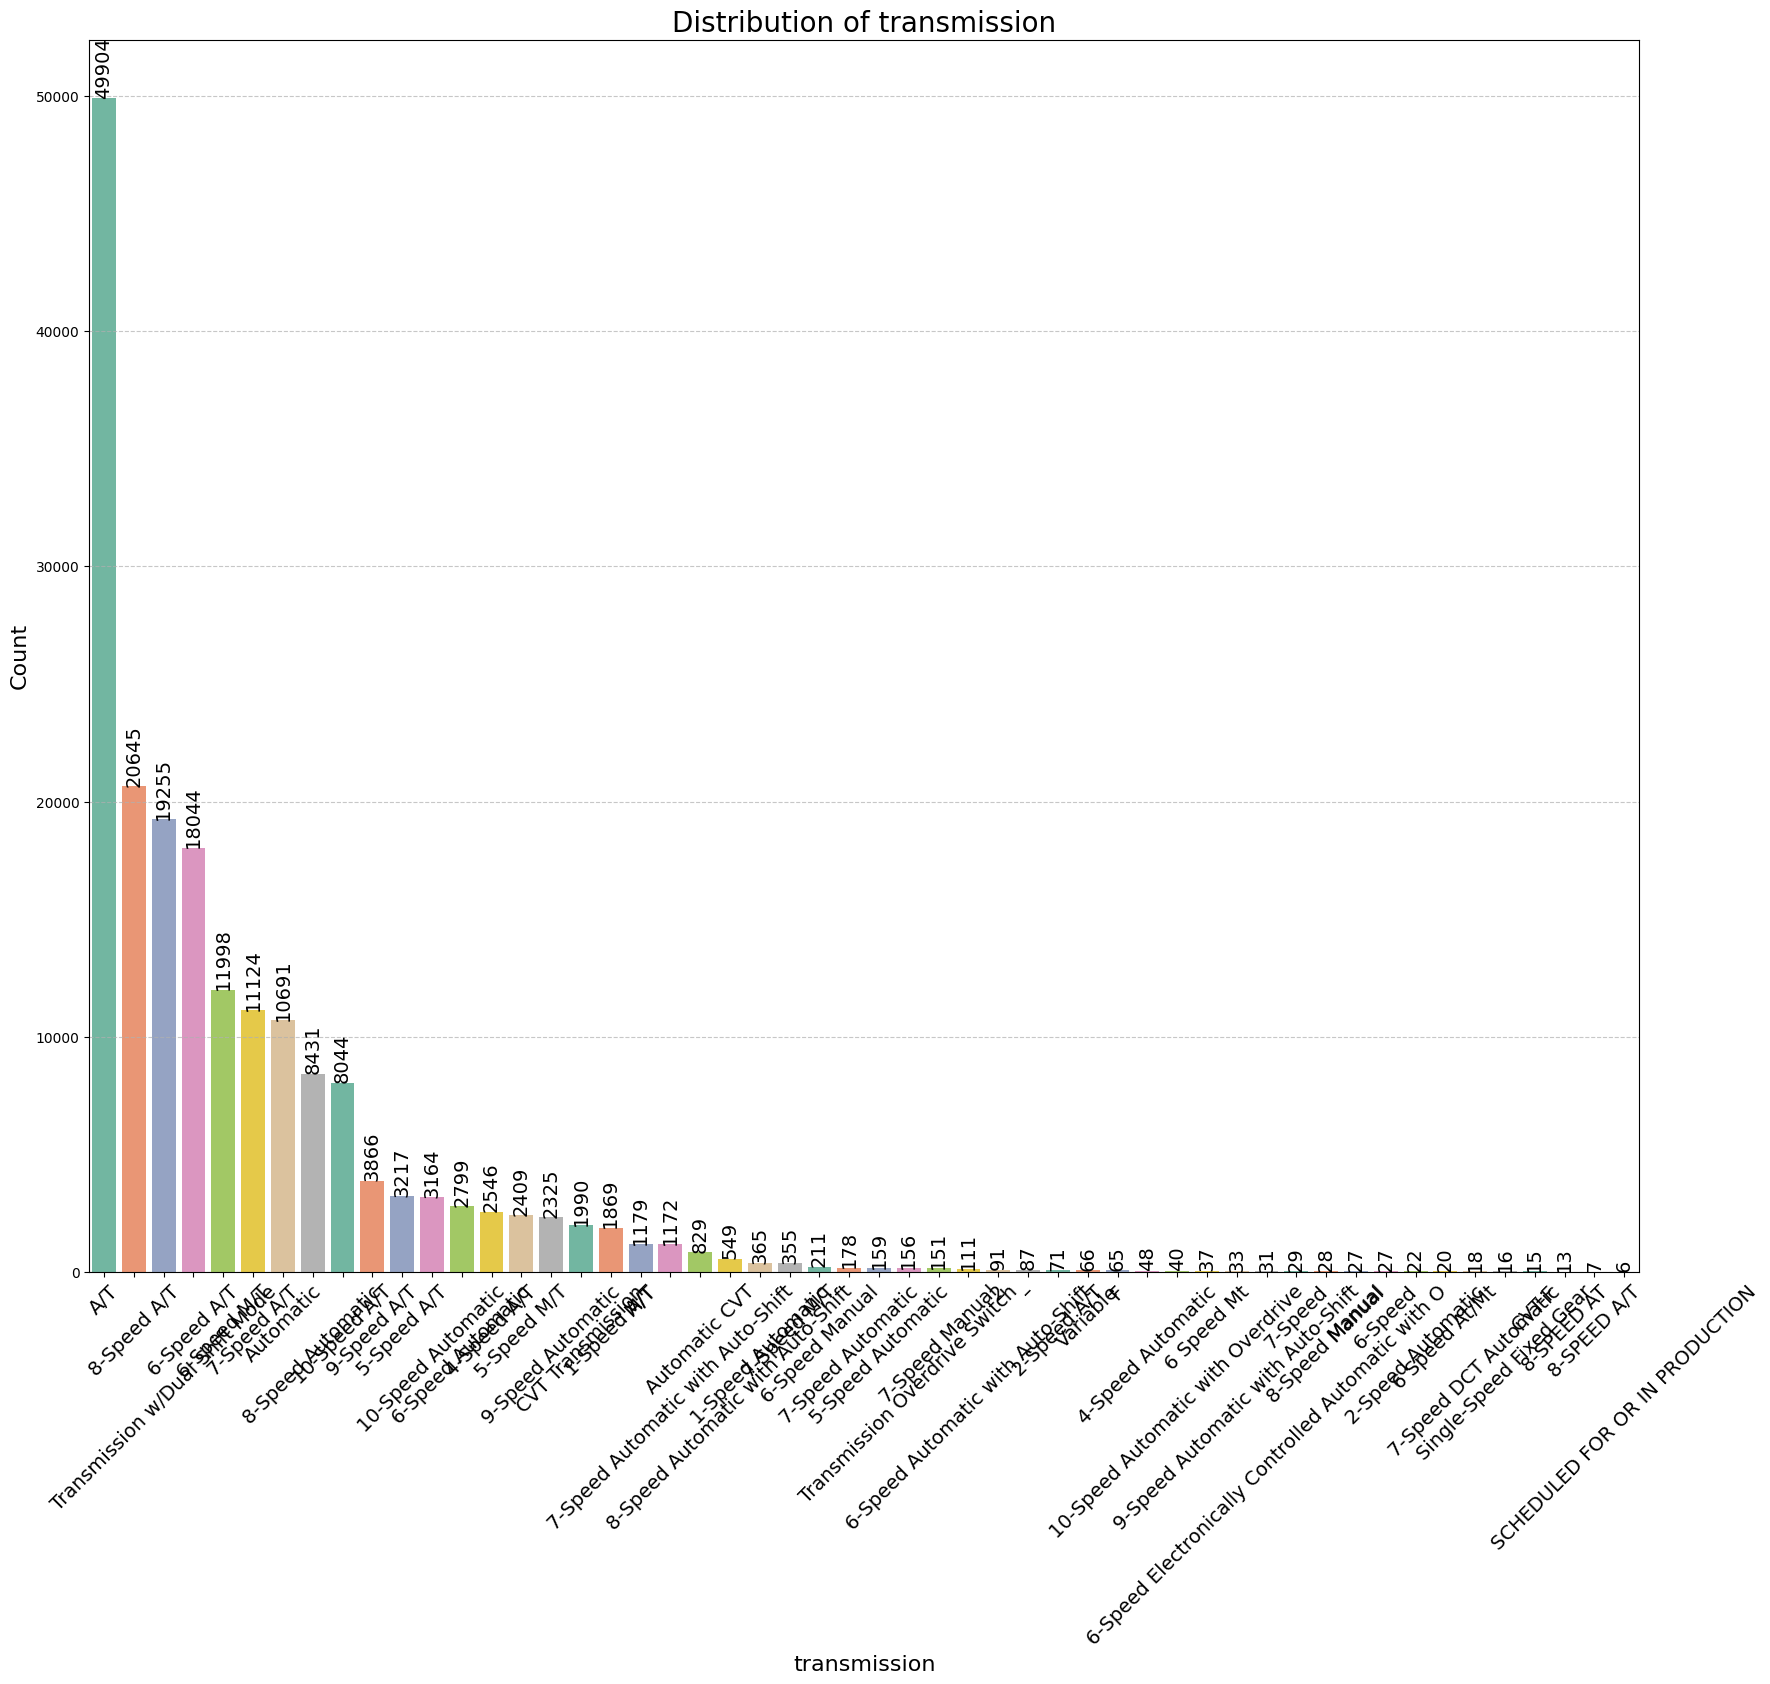

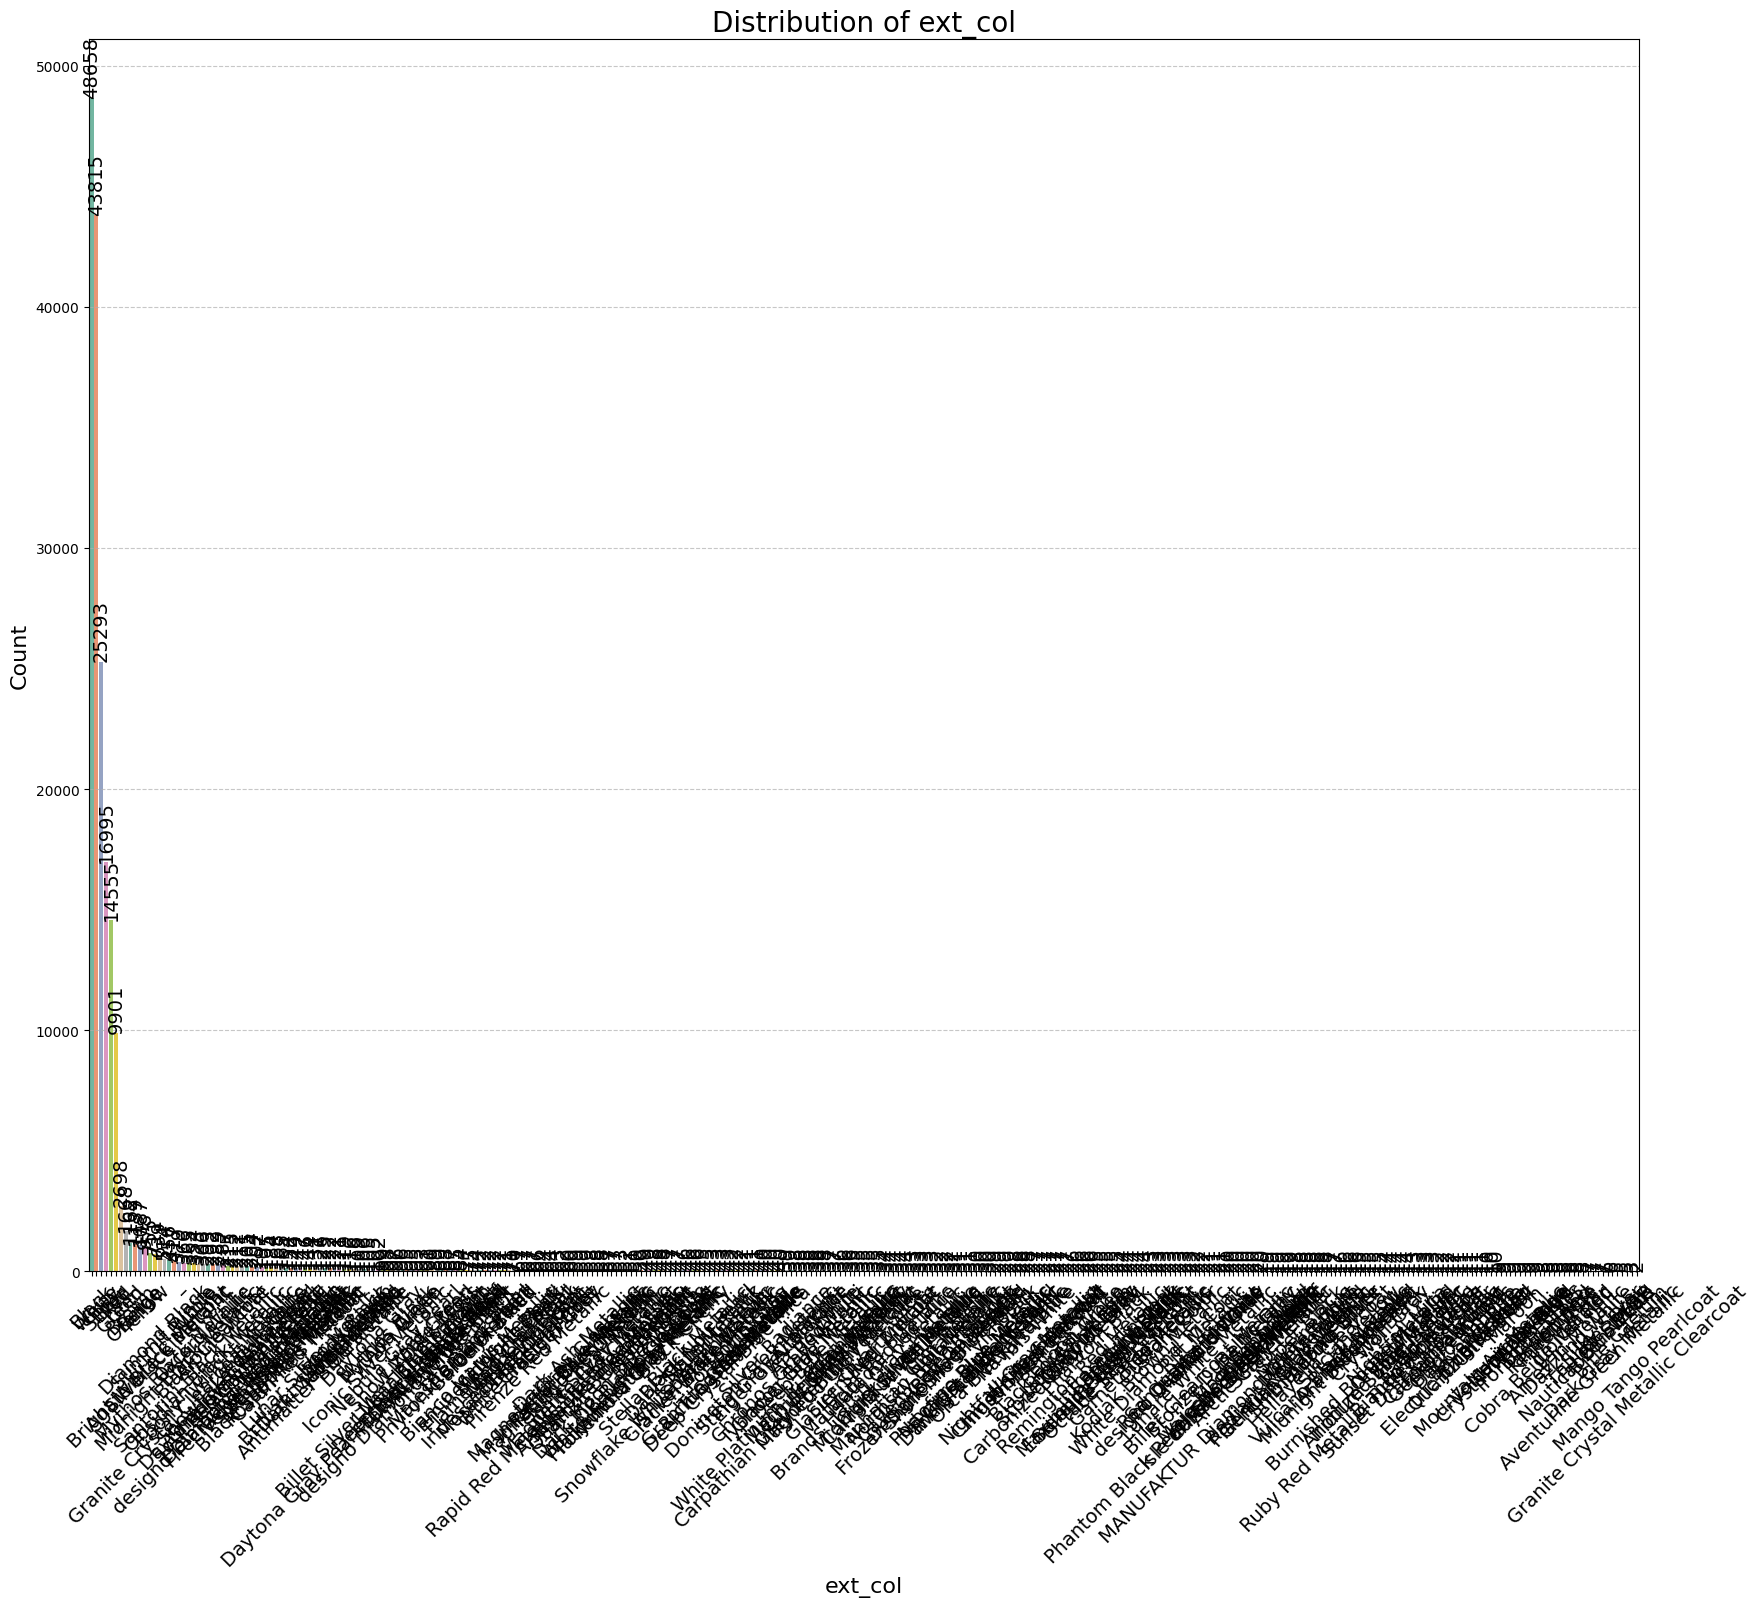

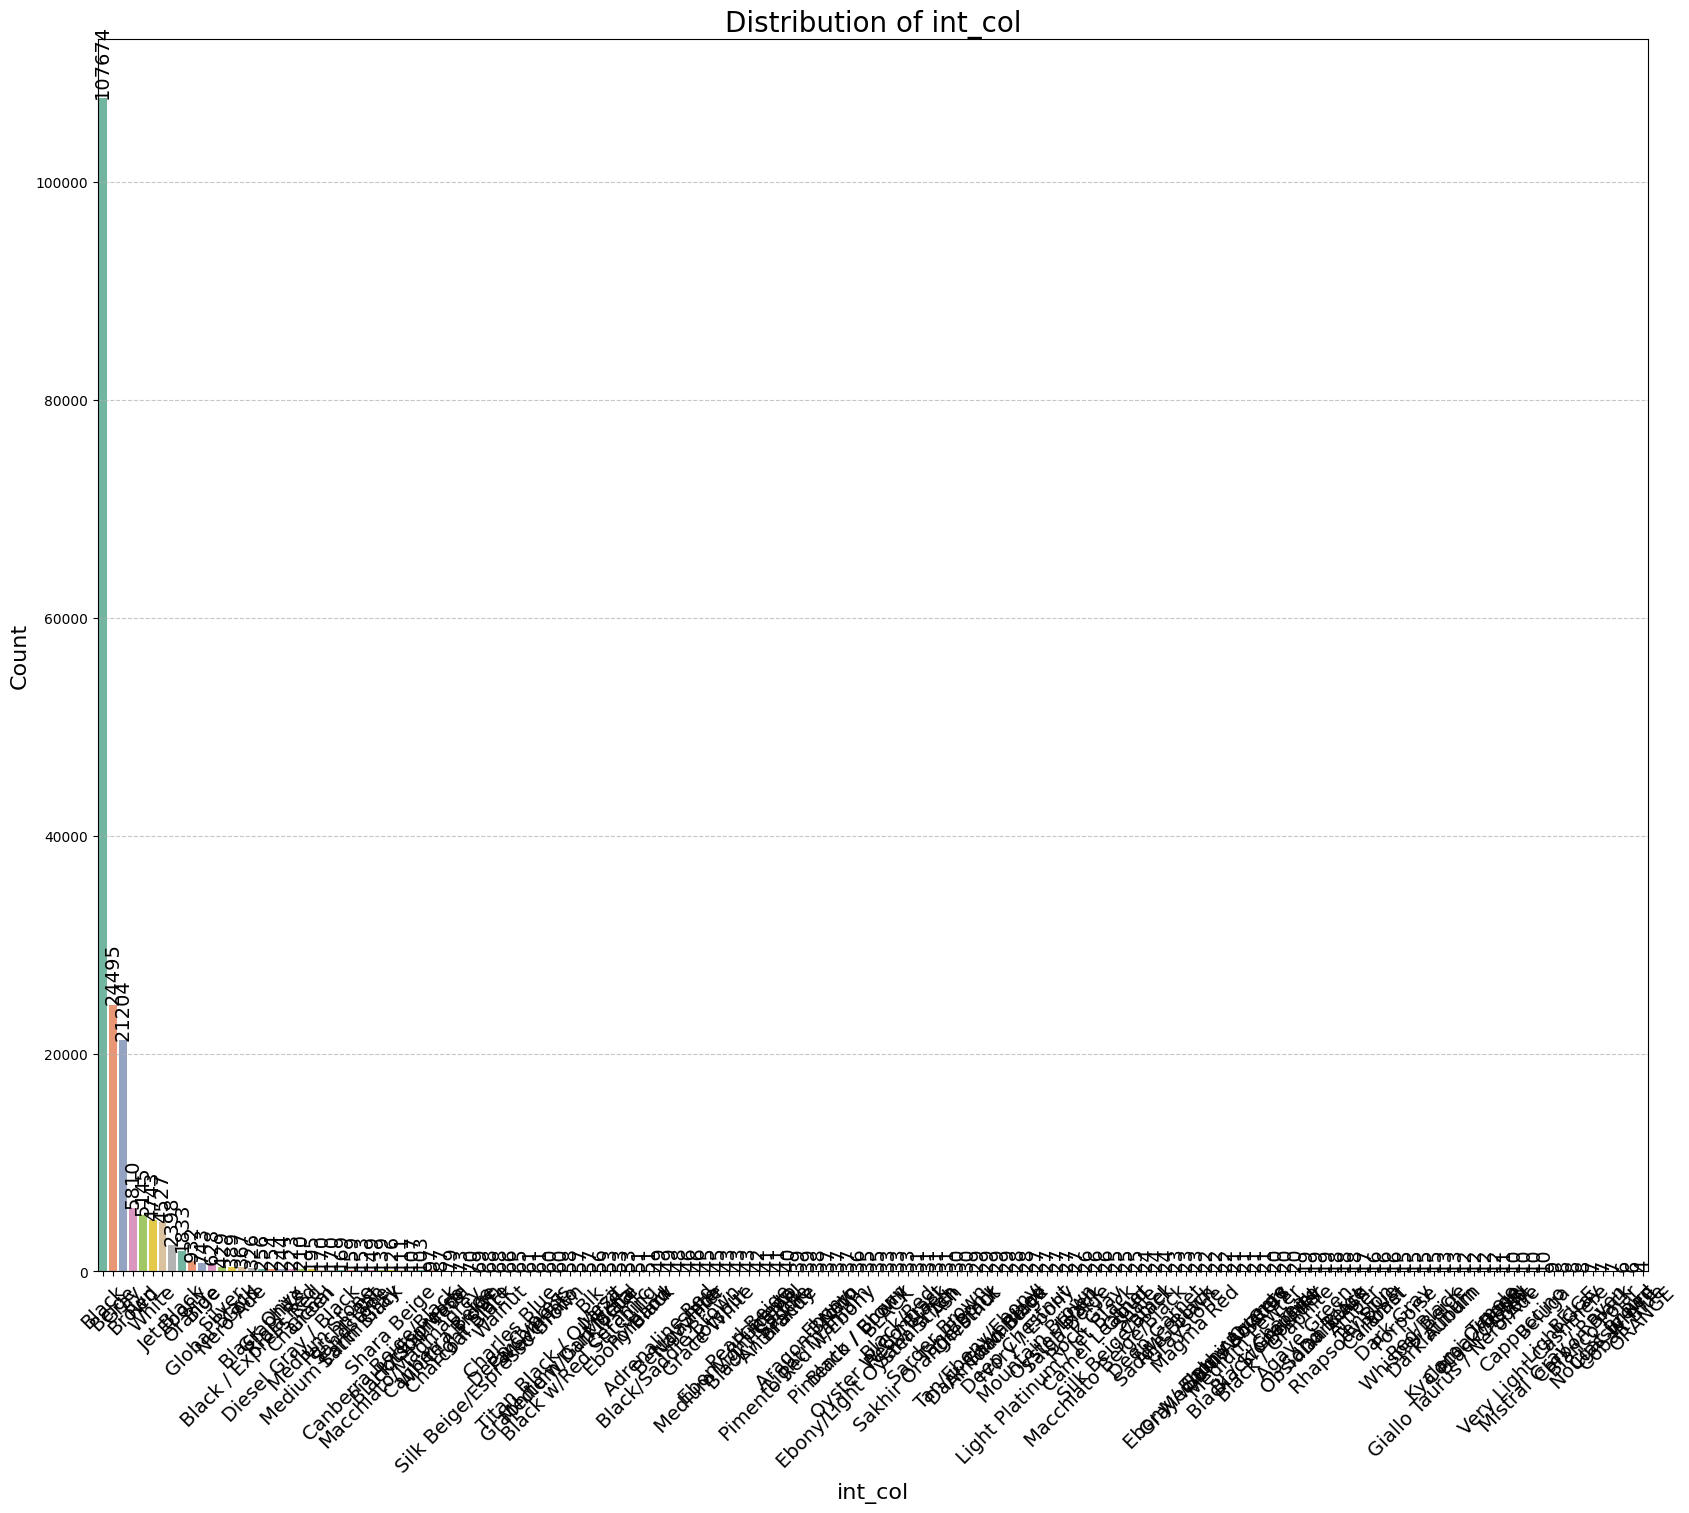

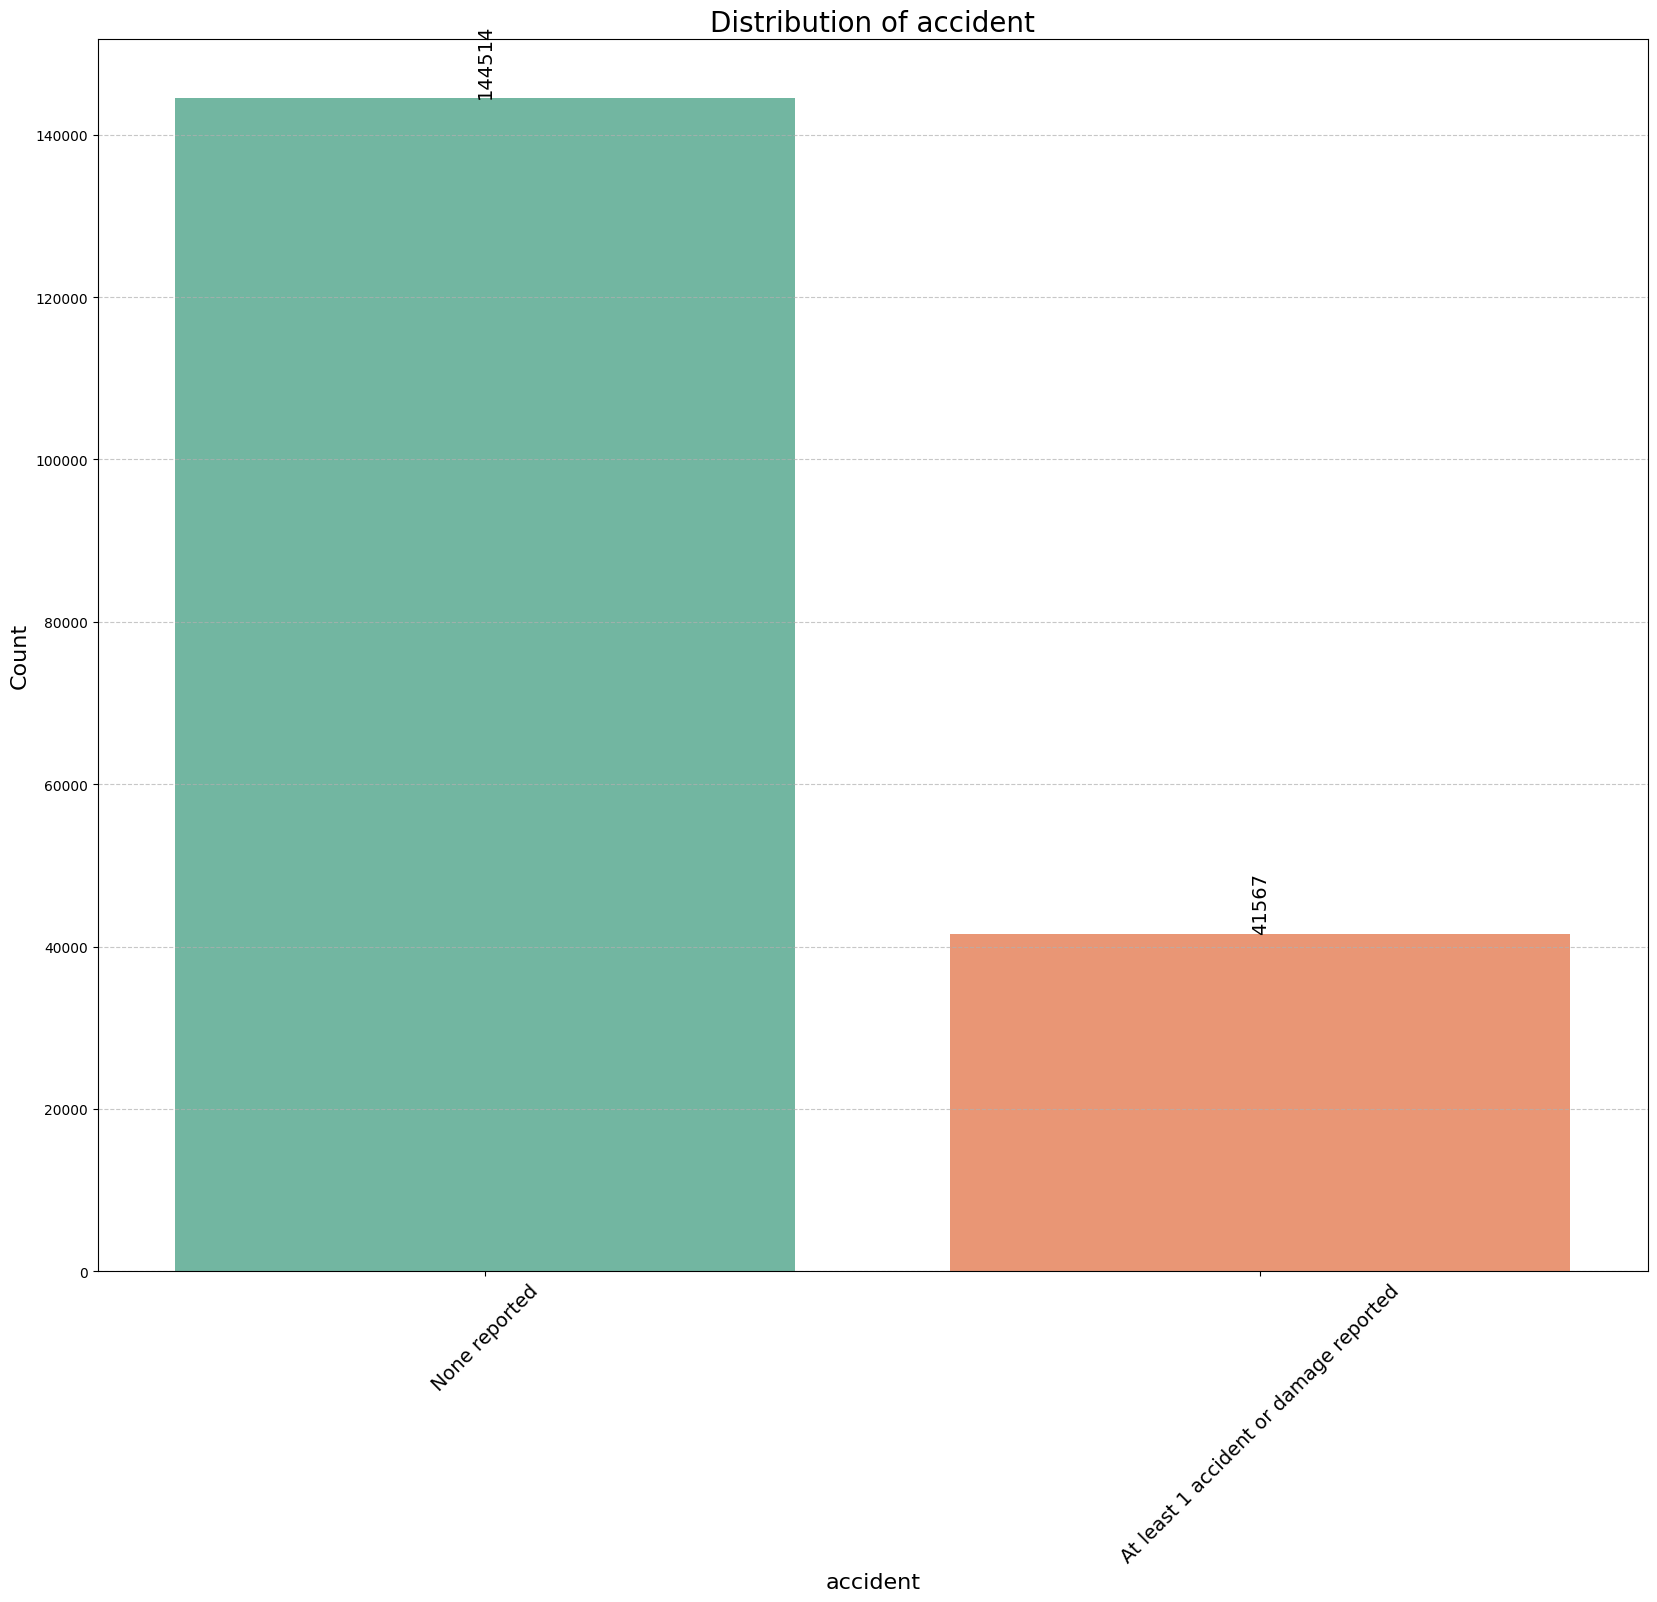

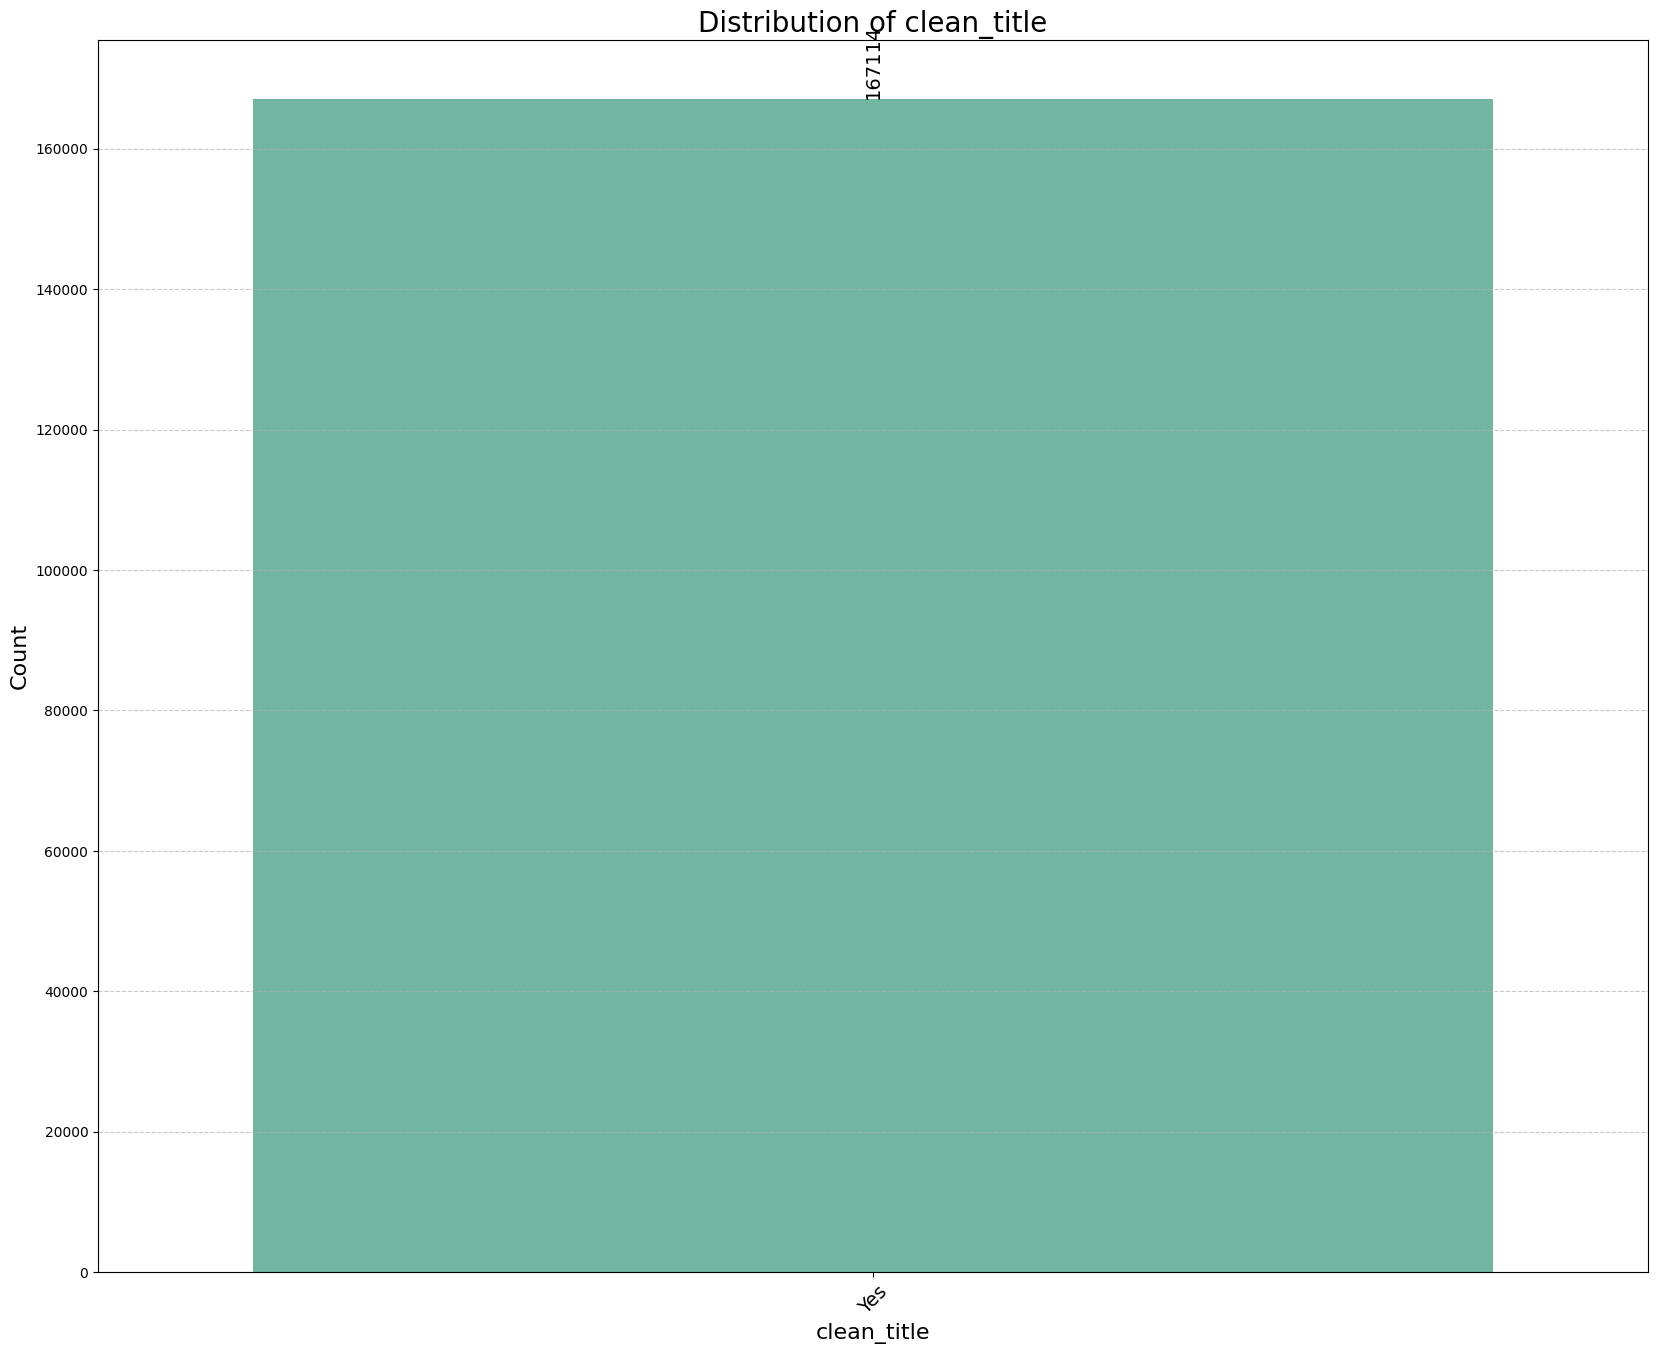

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate count plots for each categorical column
for col in obj_cols:
    plt.figure(figsize=(20, 16))  # Adjust the figure size to accommodate long labels
    sns.countplot(data=train, x=col, order=train[col].value_counts().index, palette="Set2")  # Sort bars by count

    # Add title and axis labels
    plt.title(f"Distribution of {col}", fontsize=20)
    plt.xlabel(col, fontsize=16)
    plt.ylabel("Count", fontsize=16)
    
    # Annotate bars with counts, rotated 90 degrees
    for p in plt.gca().patches:
        plt.text(p.get_x() + p.get_width() / 2, p.get_height(), 
                 f'{int(p.get_height())}', ha='center', va='bottom', fontsize=14, rotation=90)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, fontsize=14)

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()


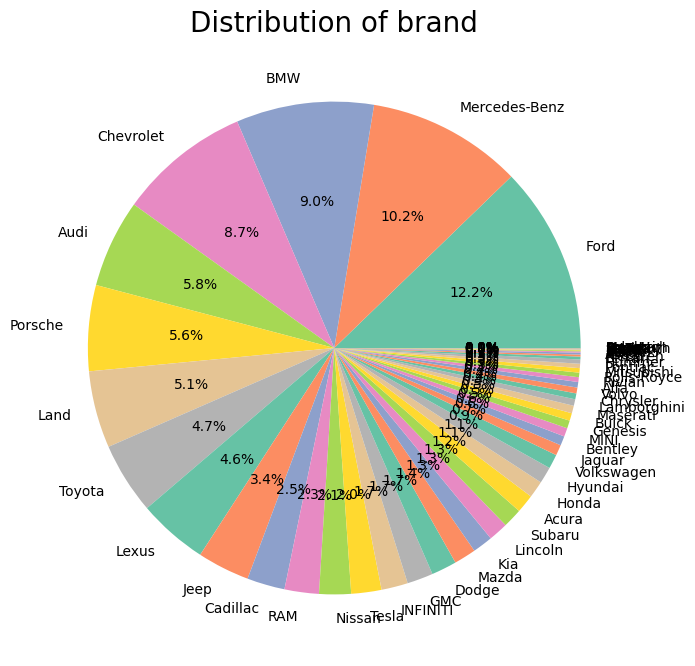

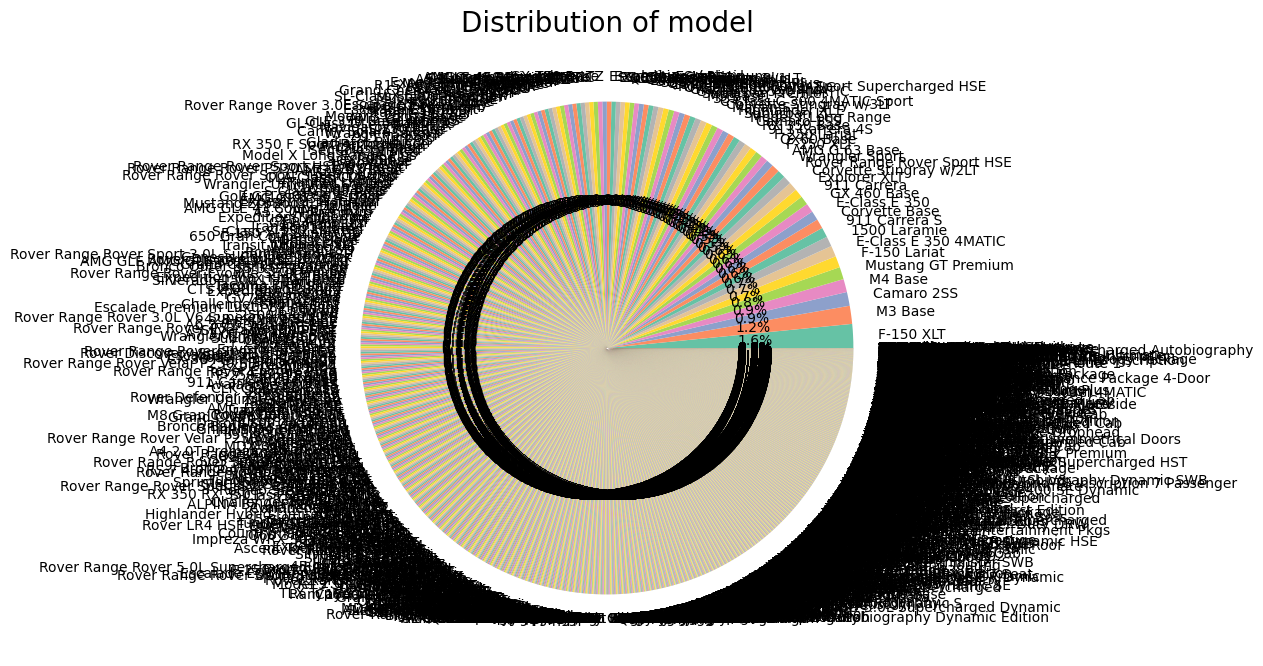

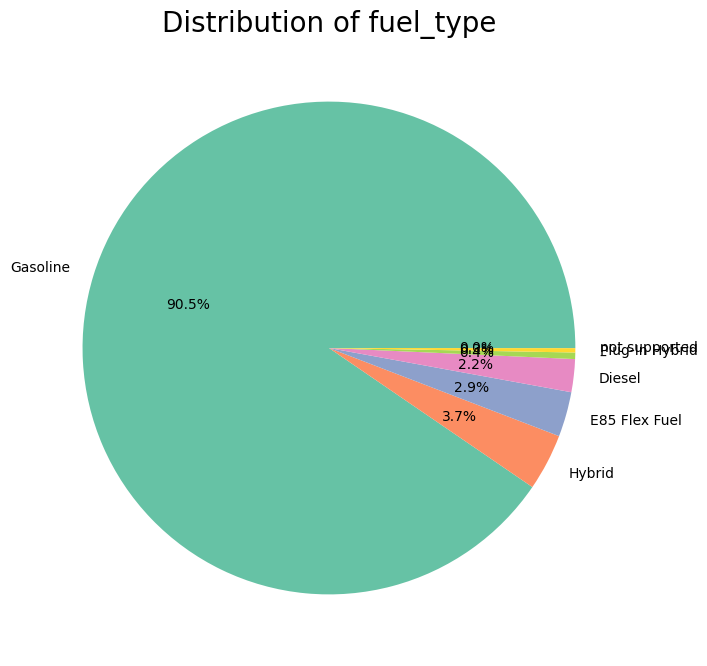

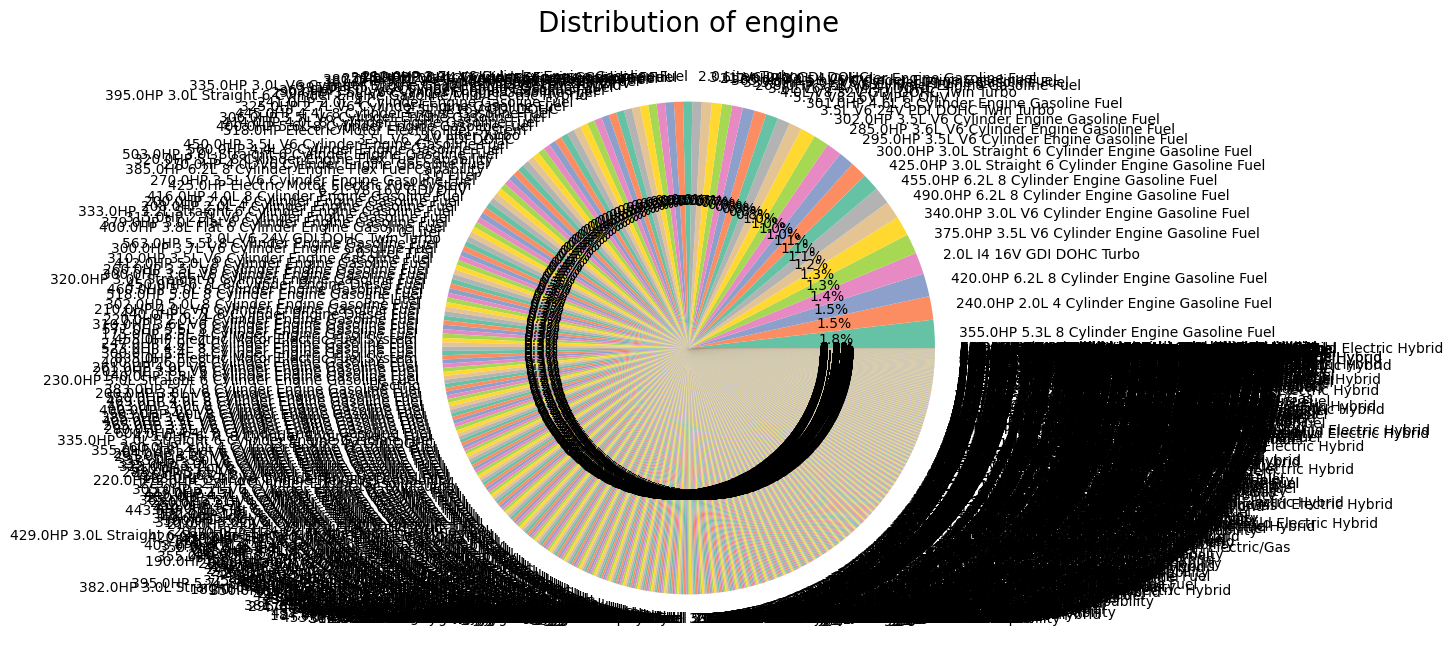

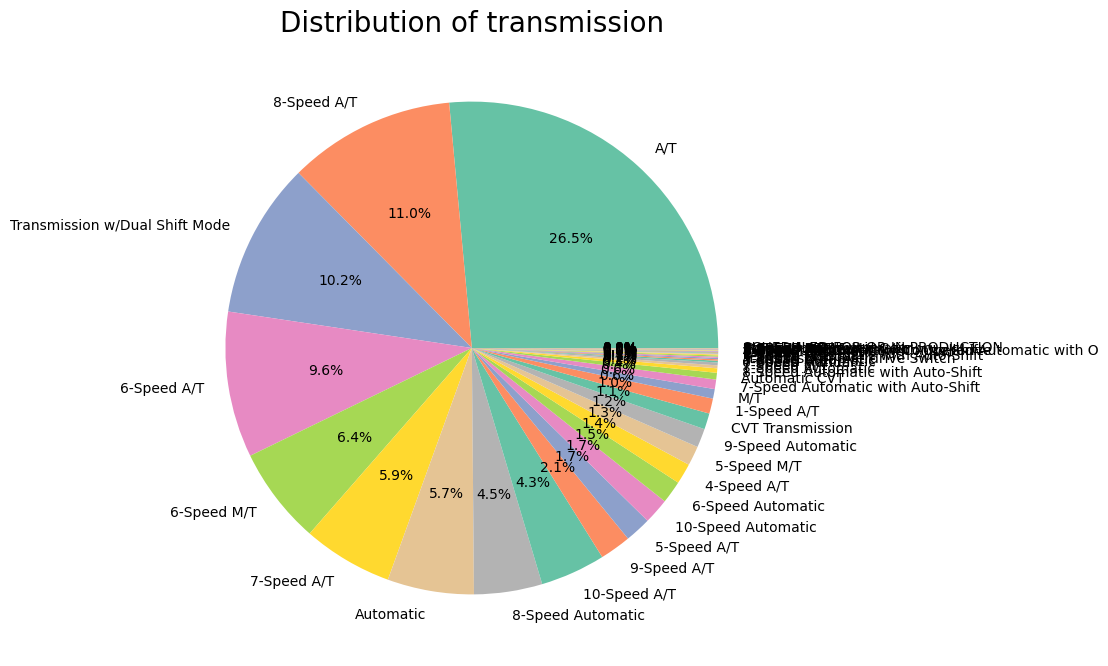

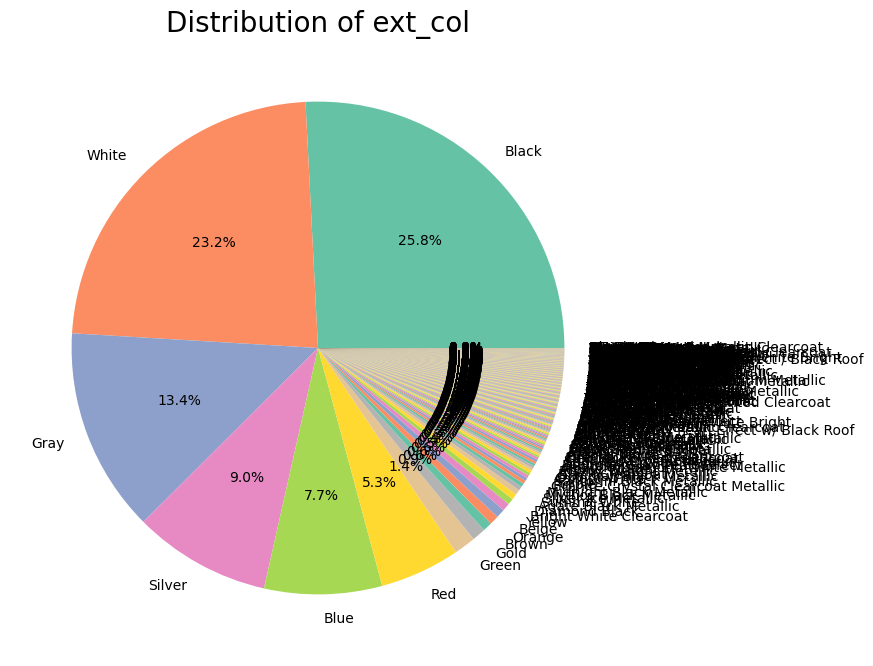

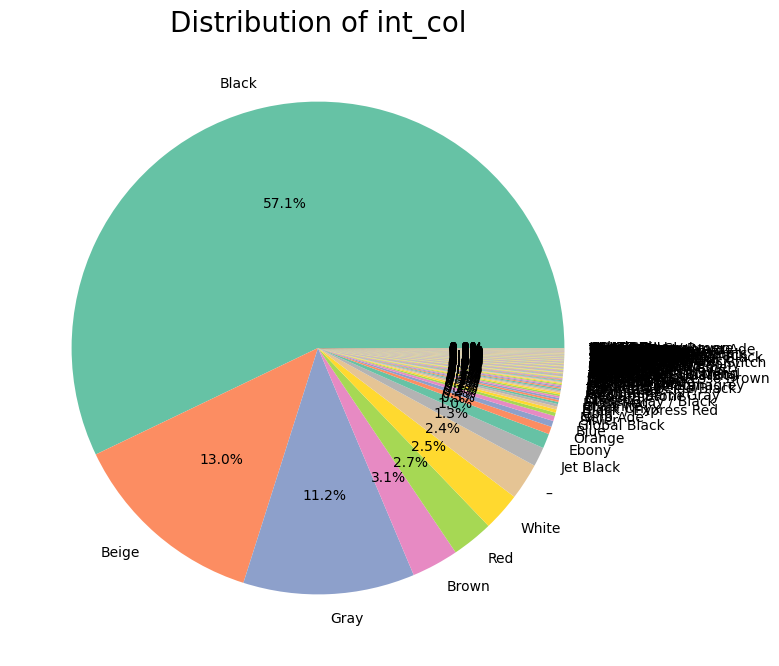

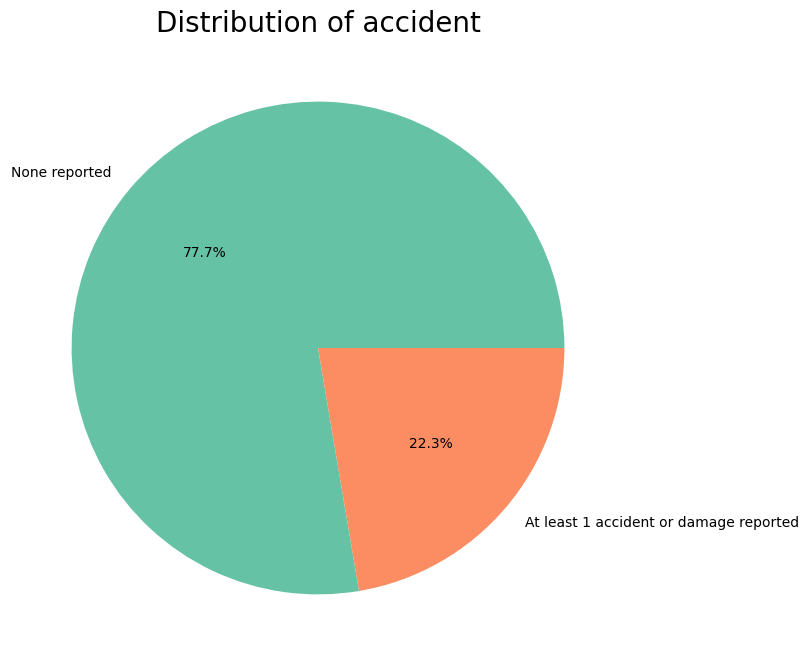

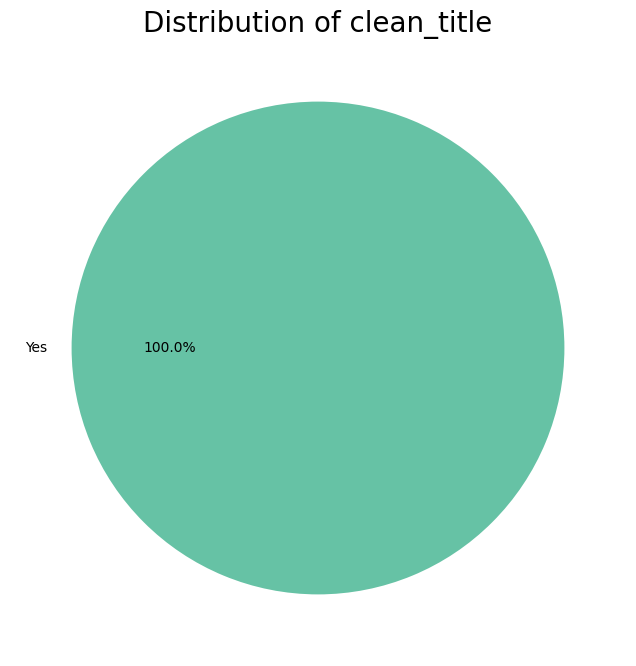

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate pie charts for each categorical column
for col in obj_cols:
    plt.figure(figsize=(10, 8))  # Adjust the figure size
    data = train[col].value_counts()  # Get the counts of each category
    
    # Plot a pie chart
    plt.pie(data, labels=data.index, autopct='%1.1f%%', colors=sns.color_palette("Set2", len(data)))
    
    # Add a title
    plt.title(f"Distribution of {col}", fontsize=20)
    
    # Show the plot
    plt.show()

# Some more EDA for deciding to filling missing values

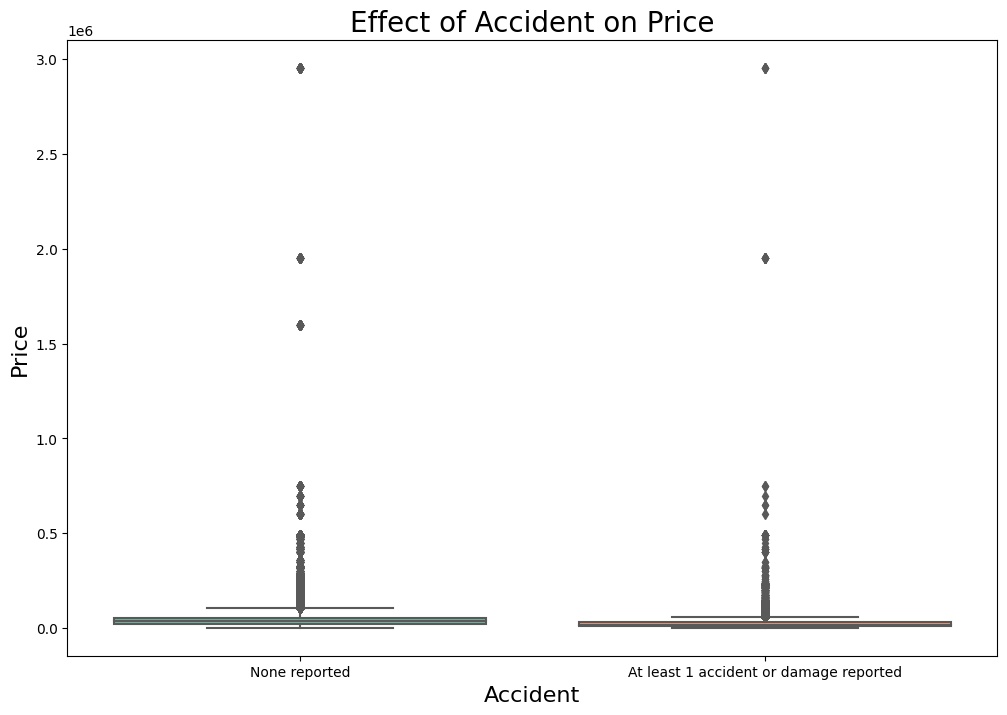

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(data=train, x='accident', y='price', palette="Set2")

# Add title and axis labels
plt.title('Effect of Accident on Price', fontsize=20)
plt.xlabel('Accident', fontsize=16)
plt.ylabel('Price', fontsize=16)

# Show the plot
plt.show()


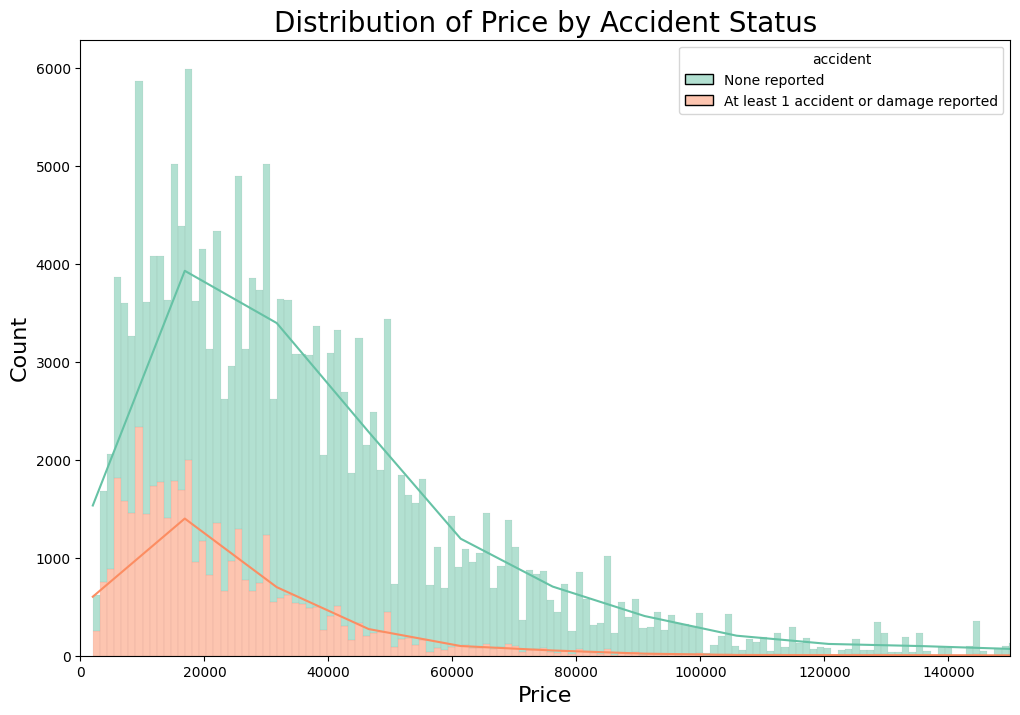

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.histplot(data=train, x='price', hue='accident', multiple='stack', palette="Set2", kde=True)

# Add title and axis labels
plt.title('Distribution of Price by Accident Status', fontsize=20)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Zoom in to a specific area by setting x-axis limits
plt.xlim(0, 150000)  # Adjust these values to zoom in on the desired range

# Show the plot
plt.show()

In [12]:
# It is concluded that there is no significant effect of any particular category of accident on Price of the car.

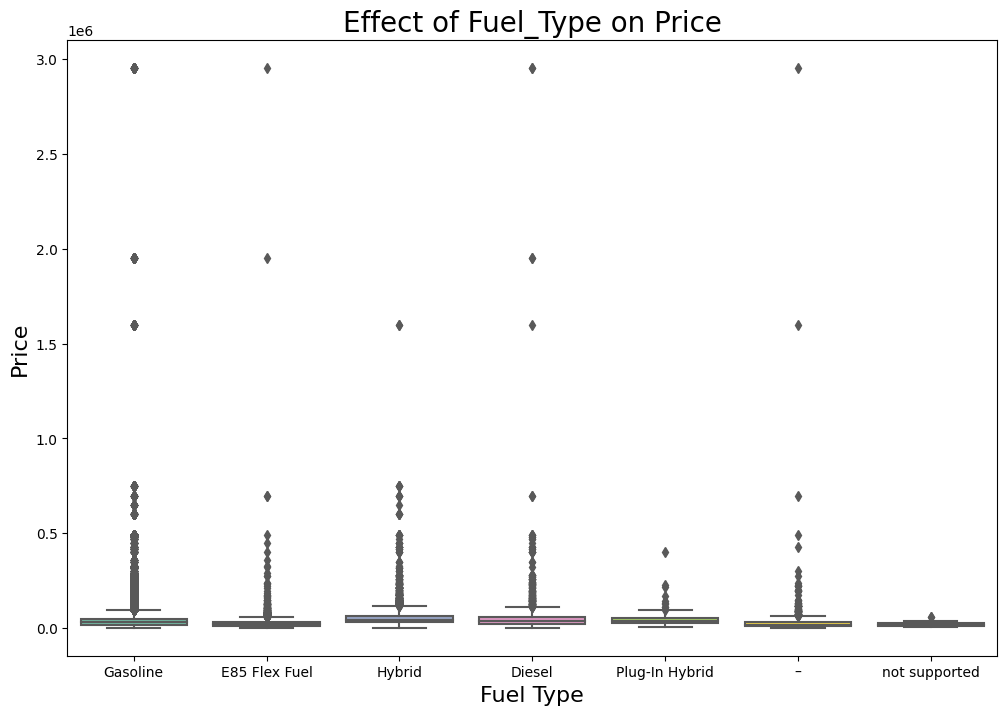

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(data=train, x='fuel_type', y='price', palette="Set2")

# Add title and axis labels
plt.title('Effect of Fuel_Type on Price', fontsize=20)
plt.xlabel('Fuel Type', fontsize=16)
plt.ylabel('Price', fontsize=16)

# Show the plot
plt.show()


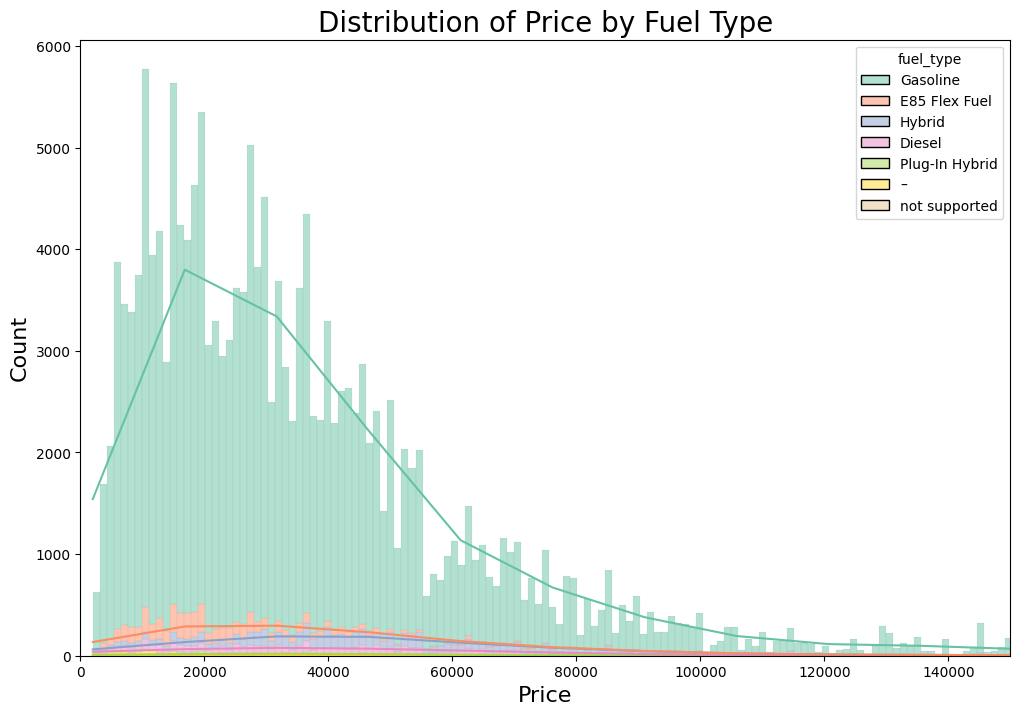

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.histplot(data=train, x='price', hue='fuel_type', multiple='stack', palette="Set2", kde=True)

# Add title and axis labels
plt.title('Distribution of Price by Fuel Type', fontsize=20)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Zoom in to a specific area by setting x-axis limits
plt.xlim(0, 150000)  # Adjust these values to zoom in on the desired range

# Show the plot
plt.show()

In [15]:
# # It is clear that : 
# 1. Clean_title has only 'Yes' and also 11.36 % missing data.
#    So, missing values can be imputed with 'missing'.
# 2. For missing values of 1.3%, imputation in 'Accident', we have to see if 77% of 'None Reported' is causing any bias.
#    Its not causing any, as we can see.
#    So, for imputation of missing values in 'fuel_type', we can go with the mode.
# 3. For fuel type, it too occours to be unbiased. Thus, same here, i.e. we can go with the mode

In [16]:
def fill_na(data):
    for col in ['accident', 'clean_title', 'fuel_type']:
        if col=='clean_title':
            data[col].fillna(value='missing', inplace=True)
        else:
            mode_value = data[col].mode()[0]
            data[col].fillna(value=mode_value, inplace=True)
            
fill_na(train)

# Exploring numerical columns, outliers and target column

In [17]:
train.describe()

model_year         milage         price
count  188533.000000  188533.000000  1.885330e+05
mean     2015.829998   65705.295174  4.387802e+04
std         5.660967   49798.158076  7.881952e+04
min      1974.000000     100.000000  2.000000e+03
25%      2013.000000   24115.000000  1.700000e+04
50%      2017.000000   57785.000000  3.082500e+04
75%      2020.000000   95400.000000  4.990000e+04
max      2024.000000  405000.000000  2.954083e+06

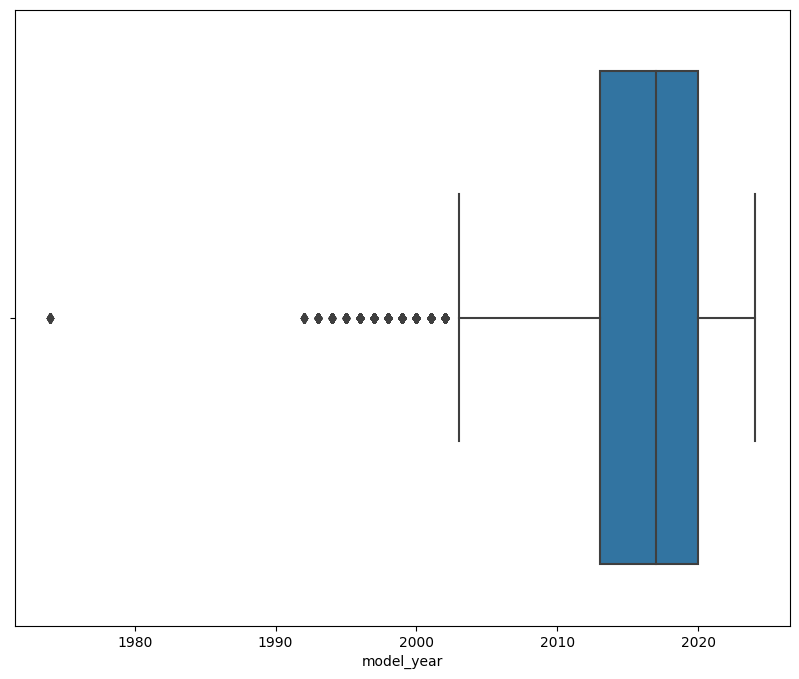

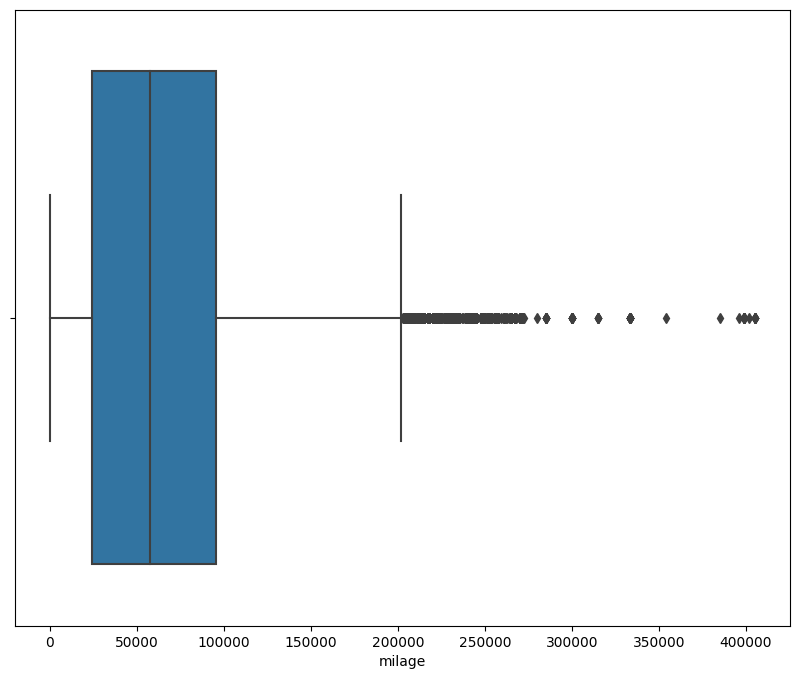

In [18]:
for col in (int_cols):
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=train, x=col)
    plt.show()

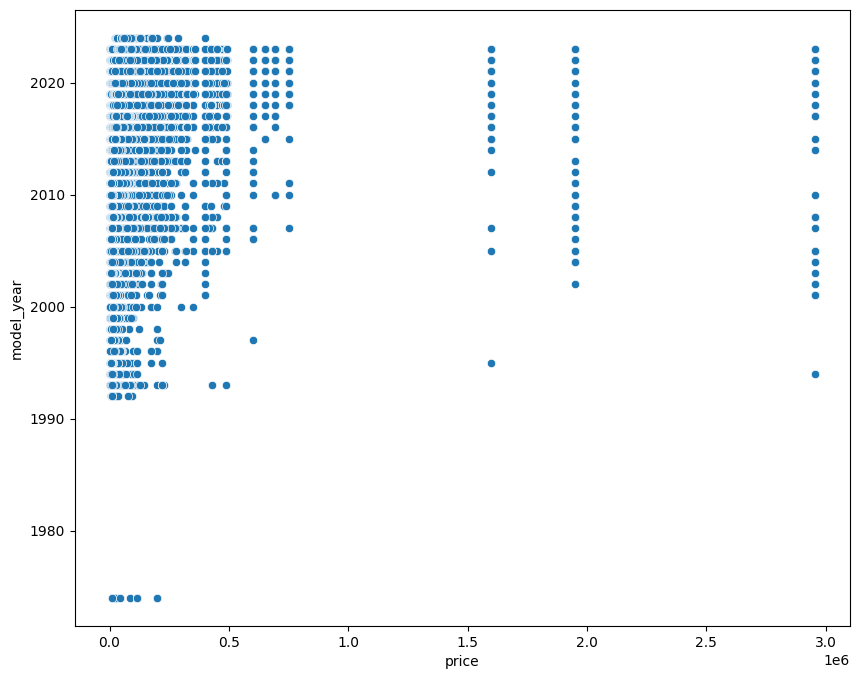

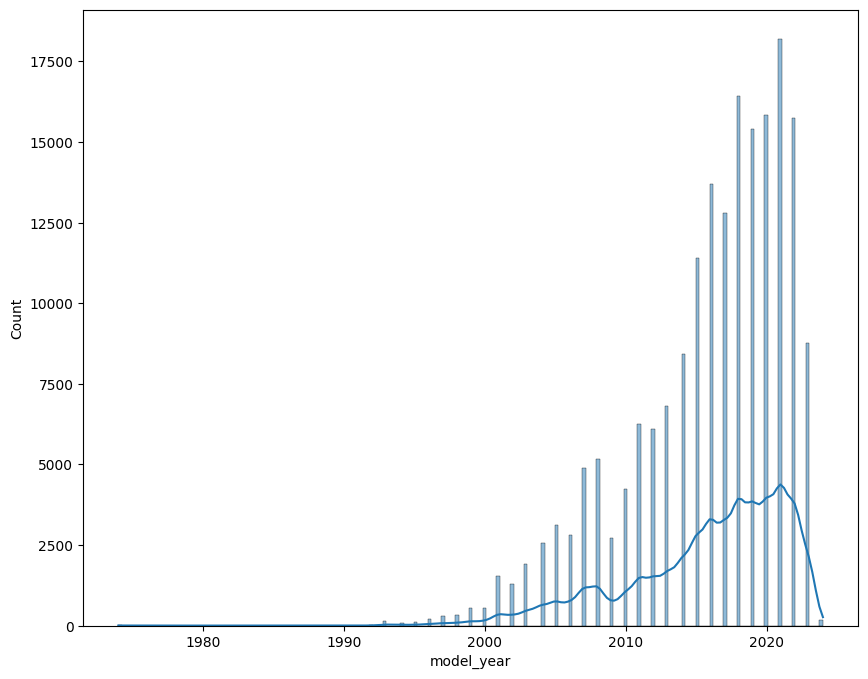

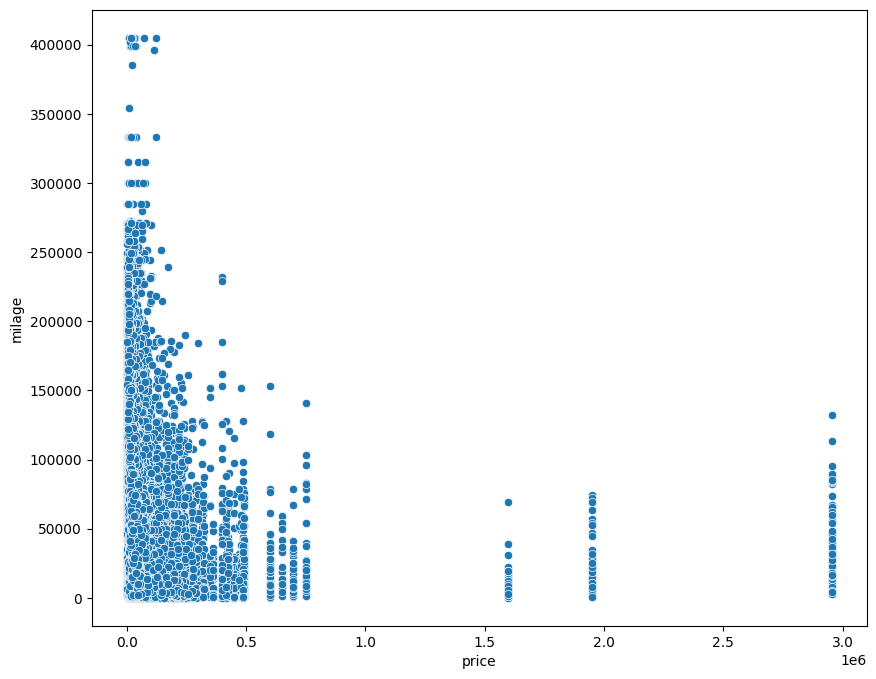

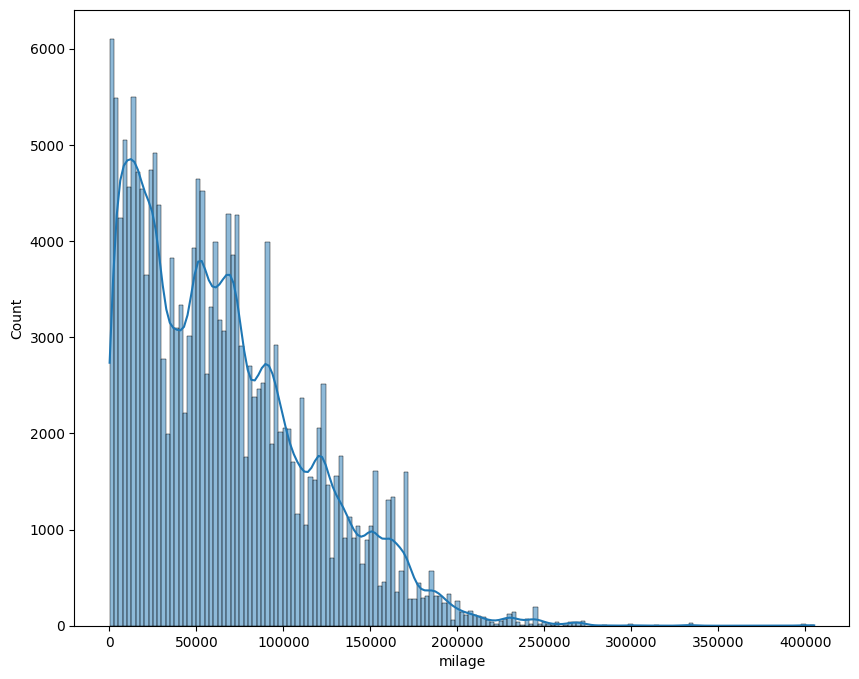

In [19]:
for col in int_cols:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=train, x='price', y=col)
    plt.show()
    plt.figure(figsize=(10, 8))
    sns.histplot(data=train, x=col, kde=True)
    plt.show()

In [20]:
def calculate_iqr_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return Q1, Q3, IQR, lower_bound, upper_bound

# Calculate and print values for 'model_year'
model_year_Q1, model_year_Q3, model_year_IQR, model_year_lower_bound, model_year_upper_bound = calculate_iqr_bounds(train['model_year'])
print(f"Model Year - Q1: {model_year_Q1}, Q3: {model_year_Q3}, IQR: {model_year_IQR}")
print(f"Model Year - Lower Bound: {model_year_lower_bound}, Upper Bound: {model_year_upper_bound}")

# Calculate and print values for 'mileage'
mileage_Q1, mileage_Q3, mileage_IQR, mileage_lower_bound, mileage_upper_bound = calculate_iqr_bounds(train['milage'])
print(f"Milage - Q1: {mileage_Q1}, Q3: {mileage_Q3}, IQR: {mileage_IQR}")
print(f"Milage - Lower Bound: {mileage_lower_bound}, Upper Bound: {mileage_upper_bound}")

Model Year - Q1: 2013.0, Q3: 2020.0, IQR: 7.0
Model Year - Lower Bound: 2002.5, Upper Bound: 2030.5
Milage - Q1: 24115.0, Q3: 95400.0, IQR: 71285.0
Milage - Lower Bound: -82812.5, Upper Bound: 202327.5


In [21]:
# Count outliers for 'model_year'
model_year_outliers_below = train[train['model_year'] < model_year_lower_bound].shape[0]
model_year_outliers_above = train[train['model_year'] > model_year_upper_bound].shape[0]

print(f"Model Year - Outliers below lower bound: {model_year_outliers_below}")
print(f"Model Year - Outliers above upper bound: {model_year_outliers_above}")

# Count outliers for 'mileage'
mileage_outliers_below = train[train['milage'] < mileage_lower_bound].shape[0]
mileage_outliers_above = train[train['milage'] > mileage_upper_bound].shape[0]

print(f"Mileage - Outliers below lower bound: {mileage_outliers_below}")
print(f"Mileage - Outliers above upper bound: {mileage_outliers_above}")

Model Year - Outliers below lower bound: 5132
Model Year - Outliers above upper bound: 0
Mileage - Outliers below lower bound: 0
Mileage - Outliers above upper bound: 1766


In [22]:
(5132+1766)/len(train) * 100

3.6587759172134318

In [23]:
train['price'].describe()

count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

In [24]:
price_Q1, price_Q3, price_IQR, price_lower_bound, price_upper_bound = calculate_iqr_bounds(train['price'])
print(f"Price - Q1: {price_Q1}, Q3: {price_Q3}, IQR: {price_IQR}")
print(f"Price - Lower Bound: {price_lower_bound}, Upper Bound: {price_upper_bound}")
outliers_above_upper_bound = train[train['price'] > 0.1e6].shape[0]
print(f"Number of values above the upper bound: {outliers_above_upper_bound}")

Price - Q1: 17000.0, Q3: 49900.0, IQR: 32900.0
Price - Lower Bound: -32350.0, Upper Bound: 99250.0
Number of values above the upper bound: 10437


In [25]:
0.1e6

100000.0

<Axes: xlabel='price'>

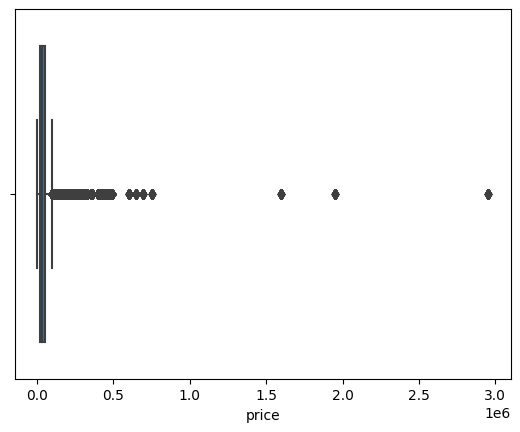

In [26]:
sns.boxplot(data=train, x='price')

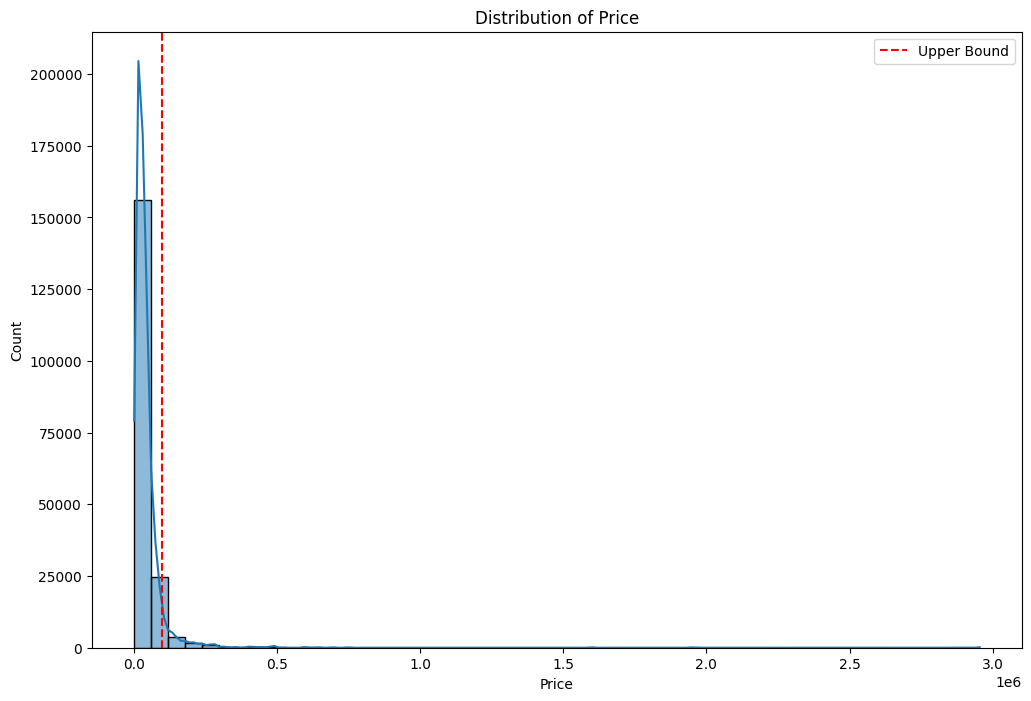

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.histplot(train['price'], bins=50, kde=True)
plt.axvline(x=price_upper_bound, color='r', linestyle='--', label='Upper Bound')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

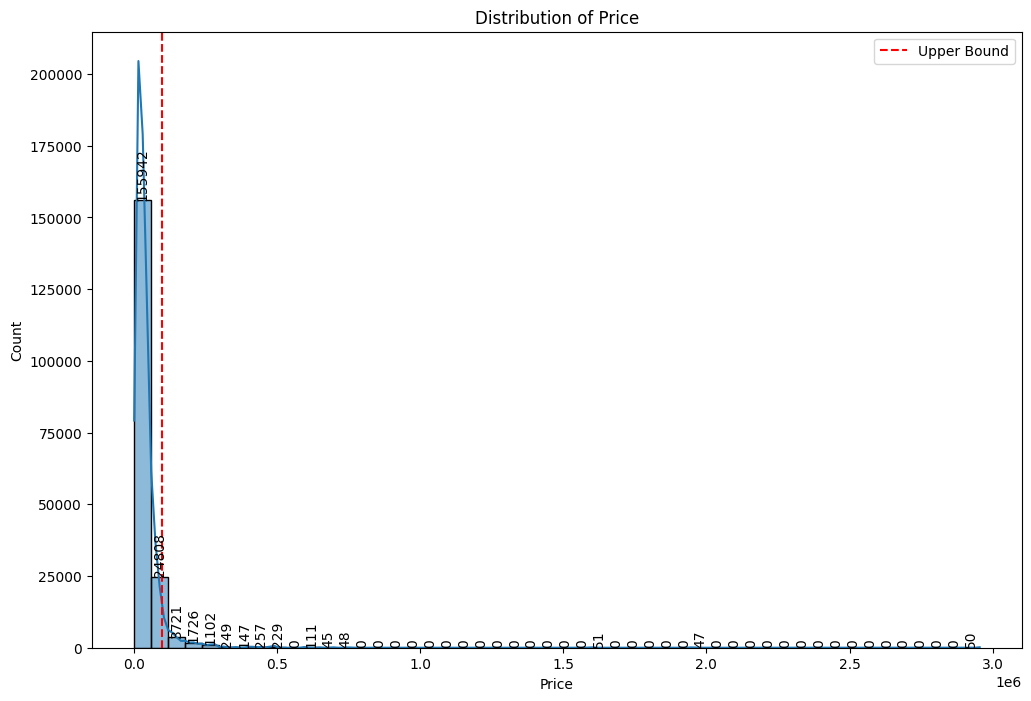

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(12, 8))
histplot = sns.histplot(train['price'], bins=50, kde=True)

# Get the counts and bin edges
counts, bin_edges = np.histogram(train['price'], bins=50)

# Add a vertical line for the upper bound
plt.axvline(x=price_upper_bound, color='r', linestyle='--', label='Upper Bound')

# Add titles and labels
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()

# Annotate counts above each bin
for i in range(len(counts)):
    plt.text(bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2, counts[i], 
             f'{int(counts[i])}', ha='center', va='bottom', fontsize=10, rotation=90)

# Show the plot
plt.show()

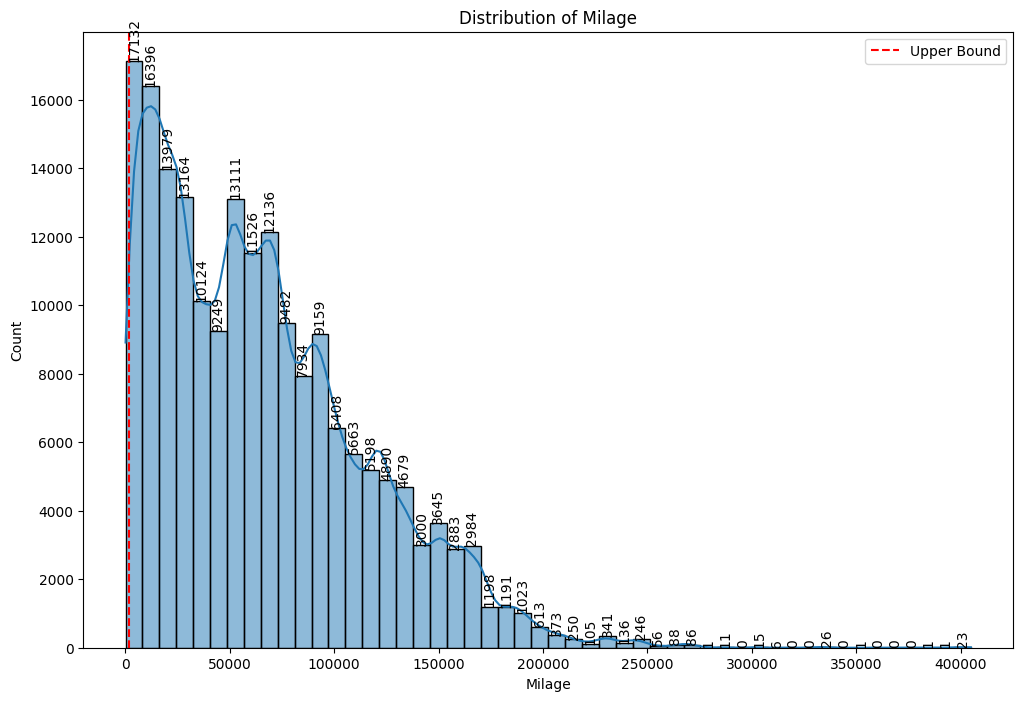

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(12, 8))
histplot_milage = sns.histplot(train['milage'], bins=50, kde=True)

# Get the counts and bin edges
counts_milage, bin_edges_milage = np.histogram(train['milage'], bins=50)

# Add a vertical line for the upper bound (replace `milage_upper_bound` with your actual value)
plt.axvline(x=mileage_outliers_above, color='r', linestyle='--', label='Upper Bound')

# Add titles and labels
plt.title('Distribution of Milage')
plt.xlabel('Milage')
plt.ylabel('Count')
plt.legend()

# Annotate counts above each bin
for i in range(len(counts_milage)):
    plt.text(bin_edges_milage[i] + (bin_edges_milage[i + 1] - bin_edges_milage[i]) / 2, counts_milage[i], 
             f'{int(counts_milage[i])}', ha='center', va='bottom', fontsize=10, rotation=90)

# Show the plot
plt.show()

# Outliers Removal

In [30]:
import pandas as pd

# Assuming 'train' is your DataFrame
train = train[train['price'] <= 1.5e6]

In [31]:
train.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [32]:
print("Length of train before removing outliers : ", len(train))
train = train[(train['model_year'] >= model_year_lower_bound) & (train['model_year'] <= model_year_upper_bound)]

# Remove outliers for 'milage'
train = train[(train['milage'] >= mileage_lower_bound) & (train['milage'] <= mileage_upper_bound)]

# Verify the number of rows left after removing outliers
print(f"Number of rows after removing outliers: {len(train)}")

Length of train before removing outliers :  188385
Number of rows after removing outliers: 181872


In [33]:
train.head()

brand               model  model_year  milage      fuel_type  \
id                                                                         
3         Genesis    G90 5.0 Ultimate        2017   19500       Gasoline   
4   Mercedes-Benz         Metris Base        2021    7388       Gasoline   
5            Audi       A6 2.0T Sport        2018   40950       Gasoline   
6            Audi           A8 L 3.0T        2016   62200       Gasoline   
7       Chevrolet  Silverado 1500 1LZ        2016  102604  E85 Flex Fuel   

                                               engine  \
id                                                      
3        420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4        208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
5        252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
6       333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
7   355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   

                      transmission ext_col int_col       accident clean_title  \
id                                                                              
3   Transmission w/Dual Shift Mode   Black   Black  None reported         Yes   
4                      7-Speed A/T   Black   Beige  None reported         Yes   
5                              A/T   White       –  None reported         Yes   
6                      8-Speed A/T   Black   Black  None reported         Yes   
7                              A/T   White    Gray  None reported         Yes   

    price  
id         
3   45000  
4   97500  
5   29950  
6   28500  
7   12500

In [34]:
luxury_brands = [
    'Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Lexus', 'Jaguar',
    'Bentley', 'Maserati', 'Lamborghini', 'Rolls-Royce', 'Ferrari',
    'McLaren', 'Aston', 'Genesis', 'Maserati', 'Rivian', 'Lucid',
    'Lotus', 'Maybach', 'Bugatti'
]
train['luxury'] = train['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

train.head()

brand               model  model_year  milage      fuel_type  \
id                                                                         
3         Genesis    G90 5.0 Ultimate        2017   19500       Gasoline   
4   Mercedes-Benz         Metris Base        2021    7388       Gasoline   
5            Audi       A6 2.0T Sport        2018   40950       Gasoline   
6            Audi           A8 L 3.0T        2016   62200       Gasoline   
7       Chevrolet  Silverado 1500 1LZ        2016  102604  E85 Flex Fuel   

                                               engine  \
id                                                      
3        420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4        208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
5        252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
6       333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
7   355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   

                      transmission ext_col int_col       accident clean_title  \
id                                                                              
3   Transmission w/Dual Shift Mode   Black   Black  None reported         Yes   
4                      7-Speed A/T   Black   Beige  None reported         Yes   
5                              A/T   White       –  None reported         Yes   
6                      8-Speed A/T   Black   Black  None reported         Yes   
7                              A/T   White    Gray  None reported         Yes   

    price  luxury  
id                 
3   45000       1  
4   97500       1  
5   29950       1  
6   28500       1  
7   12500       0

# Category wise handling

In [35]:
train['brand'].value_counts()
# Threshold to consider a category as rare
threshold = 150

# Identify rare categories
rare_brands = train['brand'].value_counts()[train['brand'].value_counts() < threshold].index

# Replace rare categories with 'Other'
train['brand'] = train['brand'].apply(lambda x: 'Other' if x in rare_brands else x)
train['brand'].value_counts()

brand
Ford             22270
Mercedes-Benz    18910
BMW              16435
Chevrolet        15357
Audi             10823
Porsche          10290
Land              9432
Lexus             8363
Toyota            8131
Jeep              6048
Cadillac          4600
RAM               4221
Nissan            3770
Tesla             3733
INFINITI          3257
GMC               3128
Dodge             2801
Mazda             2525
Kia               2485
Subaru            2338
Lincoln           2303
Acura             2181
Hyundai           2032
Honda             1918
Volkswagen        1667
Jaguar            1218
Bentley           1132
MINI              1037
Genesis            962
Maserati           929
Buick              924
Lamborghini        800
Chrysler           692
Volvo              684
Alfa               682
Rivian             590
Rolls-Royce        553
Other              524
Hummer             474
Mitsubishi         471
Pontiac            362
Ferrari            352
McLaren            243
Aston

In [36]:
train['model'].value_counts()
# Threshold to consider a model as rare
threshold = 100

# Identify rare models
rare_models = train['model'].value_counts()[train['model'].value_counts() < threshold].index

# Replace rare models with 'Other'
train['model'] = train['model'].apply(lambda x: 'Other' if x in rare_models else x)
train['model'].value_counts()

model
Other                49943
F-150 XLT             2892
M3 Base               1823
Camaro 2SS            1706
M4 Base               1614
                     ...  
Bentayga V8            100
CTS Base               100
Santa Fe SEL           100
X1 xDrive28i           100
SLK-Class SLK 350      100
Name: count, Length: 464, dtype: int64

In [37]:
train['fuel_type'].value_counts()
# Threshold to consider a fuel type as rare
threshold = 500  # Adjust as needed

# Identify rare fuel types
rare_fuel_types = train['fuel_type'].value_counts()[train['fuel_type'].value_counts() < threshold].index

# Replace rare fuel types with 'Other'
train['fuel_type'] = train['fuel_type'].apply(lambda x: 'Other' if x in rare_fuel_types else x)
train['fuel_type'].value_counts()

fuel_type
Gasoline          165095
Hybrid              6810
E85 Flex Fuel       5276
Diesel              3741
Plug-In Hybrid       520
Other                430
Name: count, dtype: int64

In [38]:
train['engine'].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3419
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2837
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2826
2.0L I4 16V GDI DOHC Turbo                             2676
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2442
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [39]:
import re
def extract_hp(engine_str):
    # Use regex to find the HP value
    hp_match = re.search(r'(\d+(\.\d+)?)HP', engine_str)
    return hp_match.group(1) if hp_match else pd.NA

# Apply the function to the 'engine' column to create a new 'hp' column
train['hp'] = train['engine'].apply(extract_hp)

def extract_displacement(engine_str):
    # Use regex to find the displacement value
    displacement_match = re.search(r'(\d+(\.\d+)?)L', engine_str)
    return displacement_match.group(1) if displacement_match else pd.NA

# Apply the function to the 'engine' column to create a new 'displacement' column
train['displacement'] = train['engine'].apply(extract_displacement)

def extract_cylinders(engine_str):
    # Use regex to find the number of cylinders
    cylinders_match = re.search(r'(\d+)\s+Cylinder', engine_str)
    return cylinders_match.group(1) if cylinders_match else pd.NA
train['cylinders'] = train['engine'].apply(extract_cylinders)

In [40]:
train.head(5)

brand        model  model_year  milage      fuel_type  \
id                                                                  
3         Genesis        Other        2017   19500       Gasoline   
4   Mercedes-Benz  Metris Base        2021    7388       Gasoline   
5            Audi        Other        2018   40950       Gasoline   
6            Audi        Other        2016   62200       Gasoline   
7       Chevrolet        Other        2016  102604  E85 Flex Fuel   

                                               engine  \
id                                                      
3        420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4        208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
5        252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
6       333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
7   355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   

                      transmission ext_col int_col       accident clean_title  \
id                                                                              
3   Transmission w/Dual Shift Mode   Black   Black  None reported         Yes   
4                      7-Speed A/T   Black   Beige  None reported         Yes   
5                              A/T   White       –  None reported         Yes   
6                      8-Speed A/T   Black   Black  None reported         Yes   
7                              A/T   White    Gray  None reported         Yes   

    price  luxury     hp displacement cylinders  
id                                               
3   45000       1  420.0          5.0         8  
4   97500       1  208.0          2.0         4  
5   29950       1  252.0          2.0         4  
6   28500       1  333.0          3.0         6  
7   12500       0  355.0          5.3         8

In [41]:
train.drop(['engine'], axis=1, inplace=True)

In [42]:
train.isna().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type           0
transmission        0
ext_col             0
int_col             0
accident            0
clean_title         0
price               0
luxury              0
hp              32721
displacement    13758
cylinders       37321
dtype: int64

In [43]:
# Calculate the mode of each column
mode_hp = train['hp'].mode()[0]
mode_displacement = train['displacement'].mode()[0]
mode_cylinder = train['cylinders'].mode()[0]

# Fill NaN values in each column with its mode
train['hp'] = train['hp'].fillna(mode_hp)
train['displacement'] = train['displacement'].fillna(mode_displacement)
train['cylinders'] = train['cylinders'].fillna(mode_cylinder)
train.head()

brand        model  model_year  milage      fuel_type  \
id                                                                  
3         Genesis        Other        2017   19500       Gasoline   
4   Mercedes-Benz  Metris Base        2021    7388       Gasoline   
5            Audi        Other        2018   40950       Gasoline   
6            Audi        Other        2016   62200       Gasoline   
7       Chevrolet        Other        2016  102604  E85 Flex Fuel   

                      transmission ext_col int_col       accident clean_title  \
id                                                                              
3   Transmission w/Dual Shift Mode   Black   Black  None reported         Yes   
4                      7-Speed A/T   Black   Beige  None reported         Yes   
5                              A/T   White       –  None reported         Yes   
6                      8-Speed A/T   Black   Black  None reported         Yes   
7                              A/T   White    Gray  None reported         Yes   

    price  luxury     hp displacement cylinders  
id                                               
3   45000       1  420.0          5.0         8  
4   97500       1  208.0          2.0         4  
5   29950       1  252.0          2.0         4  
6   28500       1  333.0          3.0         6  
7   12500       0  355.0          5.3         8

In [44]:
train['transmission'].value_counts()

transmission
A/T                                                   46849
8-Speed A/T                                           20592
Transmission w/Dual Shift Mode                        19110
6-Speed A/T                                           17733
6-Speed M/T                                           11114
7-Speed A/T                                           11053
Automatic                                             10679
8-Speed Automatic                                      8410
10-Speed A/T                                           8018
9-Speed A/T                                            3860
10-Speed Automatic                                     3155
5-Speed A/T                                            2853
6-Speed Automatic                                      2793
9-Speed Automatic                                      2320
CVT Transmission                                       1976
1-Speed A/T                                            1868
4-Speed A/T                

In [45]:
train['transmission'].value_counts()

# Define the threshold for rare transmission types
threshold = 1000  # Adjust as needed

# Identify rare transmission types
rare_transmissions = train['transmission'].value_counts()[train['transmission'].value_counts() < threshold].index

# Replace rare transmission types with 'Other'
train['transmission'] = train['transmission'].apply(lambda x: 'Other' if x in rare_transmissions else x)

# Display the updated value counts for the 'transmission' column
print("Updated transmission value counts:")
print(train['transmission'].value_counts())
train.head()

Updated transmission value counts:
transmission
A/T                                  46849
8-Speed A/T                          20592
Transmission w/Dual Shift Mode       19110
6-Speed A/T                          17733
6-Speed M/T                          11114
7-Speed A/T                          11053
Automatic                            10679
8-Speed Automatic                     8410
10-Speed A/T                          8018
9-Speed A/T                           3860
Other                                 3821
10-Speed Automatic                    3155
5-Speed A/T                           2853
6-Speed Automatic                     2793
9-Speed Automatic                     2320
CVT Transmission                      1976
1-Speed A/T                           1868
4-Speed A/T                           1827
5-Speed M/T                           1637
7-Speed Automatic with Auto-Shift     1162
M/T                                   1042
Name: count, dtype: int64


brand        model  model_year  milage      fuel_type  \
id                                                                  
3         Genesis        Other        2017   19500       Gasoline   
4   Mercedes-Benz  Metris Base        2021    7388       Gasoline   
5            Audi        Other        2018   40950       Gasoline   
6            Audi        Other        2016   62200       Gasoline   
7       Chevrolet        Other        2016  102604  E85 Flex Fuel   

                      transmission ext_col int_col       accident clean_title  \
id                                                                              
3   Transmission w/Dual Shift Mode   Black   Black  None reported         Yes   
4                      7-Speed A/T   Black   Beige  None reported         Yes   
5                              A/T   White       –  None reported         Yes   
6                      8-Speed A/T   Black   Black  None reported         Yes   
7                              A/T   White    Gray  None reported         Yes   

    price  luxury     hp displacement cylinders  
id                                               
3   45000       1  420.0          5.0         8  
4   97500       1  208.0          2.0         4  
5   29950       1  252.0          2.0         4  
6   28500       1  333.0          3.0         6  
7   12500       0  355.0          5.3         8

In [46]:
train['ext_col'].value_counts()

# Define the threshold for rare ext_col types
threshold = 1000  # Adjust as needed

# Identify rare ext_col types
rare_ext_cols = train['ext_col'].value_counts()[train['ext_col'].value_counts() < threshold].index

# Replace rare ext_col types with 'Other'
train['ext_col'] = train['ext_col'].apply(lambda x: 'Other' if x in rare_ext_cols else x)

# Display the updated value counts for the 'ext_col' column
print("Updated ext_col value counts:")
print(train['ext_col'].value_counts())

Updated ext_col value counts:
ext_col
Black     47236
White     42484
Gray      24742
Other     22328
Silver    16089
Blue      13850
Red        9150
Green      2312
Gold       1461
Brown      1124
Orange     1096
Name: count, dtype: int64


In [47]:
# Display the value counts for the 'int_col' column
print("Original int_col value counts:")
print(train['int_col'].value_counts())

# Define the threshold for rare int_col types
threshold = 1000  # Adjust as needed

# Identify rare int_col types
rare_int_cols = train['int_col'].value_counts()[train['int_col'].value_counts() < threshold].index

# Replace rare int_col types with 'Other'
train['int_col'] = train['int_col'].apply(lambda x: 'Other' if x in rare_int_cols else x)

# Display the updated value counts for the 'int_col' column
print("Updated int_col value counts:")
print(train['int_col'].value_counts())

Original int_col value counts:
int_col
Black           105383
Beige            22897
Gray             19198
Brown             5734
Red               5044
                 ...  
Nougat Brown         7
Classic Red          7
WHITE                6
Cobalt Blue          5
ORANGE               4
Name: count, Length: 156, dtype: int64
Updated int_col value counts:
int_col
Black        105383
Beige         22897
Gray          19198
Other         10486
Brown          5734
Red            5044
White          4688
–              4217
Jet Black      2393
Ebony          1832
Name: count, dtype: int64


In [48]:
train['accident'].value_counts()

accident
None reported                             142515
At least 1 accident or damage reported     39357
Name: count, dtype: int64

# Label encoding, train test split and Standard Scaler

In [49]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode

# Initialize the label encoder
label_encoders = {}

# Apply label encoding to each categorical column
for col in obj_cols:
    if col!='engine':
        le = LabelEncoder()
        train[col] = train[col].astype('category')
        # Fit and transform the column
        train[col] = le.fit_transform(train[col].astype(str))
        # Store the label encoder for potential inverse transformation
        label_encoders[col] = le

In [50]:
train.head()

brand  model  model_year  milage  fuel_type  transmission  ext_col  \
id                                                                       
3      14    309        2017   19500          2            20        0   
4      30    283        2021    7388          2             9        0   
5       3    309        2018   40950          2            15       10   
6       3    309        2016   62200          2            11        0   
7       8    309        2016  102604          1            15       10   

    int_col  accident  clean_title  price  luxury     hp displacement  \
id                                                                      
3         1         1            0  45000       1  420.0          5.0   
4         0         1            0  97500       1  208.0          2.0   
5         9         1            0  29950       1  252.0          2.0   
6         1         1            0  28500       1  333.0          3.0   
7         4         1            0  12500       0  355.0          5.3   

   cylinders  
id            
3          8  
4          4  
5          4  
6          6  
7          8

In [51]:
int_cols

['model_year', 'milage']

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('price', axis=1), train.price, 
                                                    test_size=0.15, random_state=669)

In [53]:
from sklearn.preprocessing import StandardScaler

# Define the numerical columns you want to scale
new_int_cols = ['model_year', 'milage', 'hp', 'displacement', 'cylinders']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the numerical columns
X_train[new_int_cols] = scaler.fit_transform(X_train[new_int_cols])
X_test[new_int_cols] = scaler.transform(X_test[new_int_cols])
# Display the first few rows of the scaled DataFrame to verify
print(X_train.head())
print(X_test.head())

        brand  model  model_year    milage  fuel_type  transmission  ext_col  \
id                                                                             
21042      23    309    1.337670 -0.623691          3            15        0   
108074     41    239    0.535636 -0.574613          2            11        9   
70634       8    401   -0.065889  0.561872          2             6       10   
98521       3     53   -0.867923  0.322180          2            11        8   
101326      3    309   -0.065889  0.225443          0            15        0   

        int_col  accident  clean_title  luxury        hp  displacement  \
id                                                                       
21042         0         1            0       0  0.540641     -0.557633   
108074        1         1            0       0 -0.647074     -0.178704   
70634         4         1            0       0  0.160572      1.185441   
98521         1         1            0       1 -1.207675     -1.31549

In [54]:
train.head()

brand  model  model_year  milage  fuel_type  transmission  ext_col  \
id                                                                       
3      14    309        2017   19500          2            20        0   
4      30    283        2021    7388          2             9        0   
5       3    309        2018   40950          2            15       10   
6       3    309        2016   62200          2            11        0   
7       8    309        2016  102604          1            15       10   

    int_col  accident  clean_title  price  luxury     hp displacement  \
id                                                                      
3         1         1            0  45000       1  420.0          5.0   
4         0         1            0  97500       1  208.0          2.0   
5         9         1            0  29950       1  252.0          2.0   
6         1         1            0  28500       1  333.0          3.0   
7         4         1            0  12500       0  355.0          5.3   

   cylinders  
id            
3          8  
4          4  
5          4  
6          6  
7          8

In [55]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (154591, 14)
y_train shape: (154591,)
X_test shape: (27281, 14)
y_test shape: (27281,)


# Baseline Predictions

In [56]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Assume X_train, X_test, y_train, y_test are already defined

# Initialize a list to store model scores
model_scores = []

# Define a function to evaluate and log the model's performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    model_scores.append((model_name, rmse))
    print(f"{model_name} RMSE: {rmse:.4f}")
    return rmse

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(alpha=1.0),
    'LassoRegression': Lasso(alpha=0.1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(eval_metric='rmse', verbose=1, random_state=42),
    'LightGBM': lgb.LGBMRegressor(verbose=1, random_state=42),
    'CatBoost': cb.CatBoostRegressor(verbose=1, random_state=42)
}

# Evaluate all models
for model_name, model in models.items():
    evaluate_model(model, X_train, X_test, y_train, y_test, model_name)

# Convert model scores to DataFrame for better readability
scores_df = pd.DataFrame(model_scores, columns=['Model', 'RMSE'])
print(scores_df)

#              Model          RMSE
# 0  LinearRegression  43801.509304
# 1   RidgeRegression  43801.509768
# 2   LassoRegression  43801.508679
# 3      DecisionTree  61247.083794
# 4      RandomForest  43368.714016
# 5  GradientBoosting  41317.975885
# 6           XGBoost  41463.791082
# 7          LightGBM  41068.184051
# 8          CatBoost  40973.399547

Training LinearRegression...
LinearRegression RMSE: 43503.2474
Training RidgeRegression...
RidgeRegression RMSE: 43503.2485
Training LassoRegression...
LassoRegression RMSE: 43503.2483
Training DecisionTree...
DecisionTree RMSE: 59527.2114
Training RandomForest...
RandomForest RMSE: 43493.3610
Training GradientBoosting...
GradientBoosting RMSE: 41224.3274
Training XGBoost...
XGBoost RMSE: 41526.3044
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 154591, number of used features: 14
[LightGBM] [Info] Start training from score 43099.547225
LightGBM RMSE: 40965.8067
Training CatBoost...
Learning rate set to 0.090797
0:	learn: 48185.0758898	total: 77.1ms	remaining: 1m 17s
1:	learn: 47139.5827866	total: 95

# Optuna - LightGBM

In [ ]:
import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Dictionary to store RMSE results and best hyperparameters
model_scores = []
best_hyperparams = {}

# Define the objective functions for each model
# Baseline - LightGBM - 41068.184051
def objective_lightgbm(trial):
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
#     }
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', -1, 20),  # -1 means no limit; expanded range
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),  # Increased range for flexibility
#         'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),  # Minimum gain to make a further partition
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),  # Useful for imbalanced classes
#         'cat_smooth': trial.suggest_int('cat_smooth', 0, 100),  # Smoothing parameter for categorical features
#         'max_bin': trial.suggest_int('max_bin', 255, 1024),  # For histogram-based 
#         'num_leaves': trial.suggest_int('num_leaves', 20, 128)  # Adjust range as needed
#     }
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 900, 1200),  # Close to the best value found
#         'max_depth': trial.suggest_int('max_depth', 18, 22),  # Slightly around the best max_depth
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.01),  # 0.001, 0.01 Around the lower bound of the best learning rates
#         'subsample': trial.suggest_uniform('subsample', 0.65, 0.9),  # Tightened around the best subsample values
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.6),  # Narrowed around the best colsample_bytree values
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1e-5),  # Focused on small regularization
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1e-4),  # Similar small regularization
#         'min_child_weight': trial.suggest_int('min_child_weight', 25, 55),  # Focused around the best values found
#         'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.05, 0.3),  # Tightened around best min_split_gain
#         'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 7.0, 9.0),  # Around the best scale_pos_weight
#         'cat_smooth': trial.suggest_int('cat_smooth', 60, 80),  # Focused around the best cat_smooth values
#         'max_bin': trial.suggest_int('max_bin', 700, 900),  # Narrowed around the best max_bin
#         'num_leaves': trial.suggest_int('num_leaves', 110, 130)  # Slightly around the best num_leaves
#     }
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 800, 1500),  # Expanded the range of estimators
    'max_depth': trial.suggest_int('max_depth', 12, 30),  # Broader range for max_depth
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.02),  # Expanded learning rate range
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),  # Wider range for subsample
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.8),  # Broader range for colsample_bytree
#     'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 1e-3),  # Expanded L2 regularization range
#     'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 1e-2),  # Broader range for L1 regularization
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 70),  # Expanded range for min_child_weight
#     'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-4, 1.0),  # Wider range for min_split_gain
    'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 12.0),  # Broader range for scale_pos_weight
    'cat_smooth': trial.suggest_int('cat_smooth', 20, 120),  # Expanded range for cat_smooth
    'max_bin': trial.suggest_int('max_bin', 200, 1000),  # Broadened range for max_bin
    'num_leaves': trial.suggest_int('num_leaves', 75, 200),  # Expanded range for num_leaves
    'n_jobs': -1  # Use all CPU cores
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse


# Define the models and their respective objective functions
model_objectives = {
   "LightGBM": objective_lightgbm,
}

# Optimize each model with Optuna and store the results
for model_name, objective in model_objectives.items():
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=200, show_progress_bar=True, n_jobs=-1)
    
    # Store the best result
    model_scores.append((model_name, study.best_value))
    best_hyperparams[model_name] = study.best_params

# Print all model scores
for model_name, rmse in model_scores:
    print(f"{model_name}: RMSE = {rmse:.4f}")

# Optional: Convert model_scores to a DataFrame for better readability
scores_df = pd.DataFrame(model_scores, columns=['Model', 'RMSE']).sort_values(by='RMSE')
print(scores_df)

# Print the best hyperparameters for each model
for model_name, params in best_hyperparams.items():
    print(f"\nBest hyperparameters for {model_name}:")
    print(params)

[I 2024-09-04 16:14:42,493] A new study created in memory with name: no-name-41a6e1a7-f463-41fa-8a8d-c5257f9bb7e2


Optimizing LightGBM...


  0%|          | 0/200 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 154591, number of used features: 14
[LightGBM] [Info] Start training from score 43099.547225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1717
[LightGBM] [Info] Number of data points in the train set: 154591, number of used features: 14
[LightGBM] [Info] Start training from score 43099.547225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1797
[LightGBM] [Info] Number of data points in the train set: 154591, number of used features: 14
[LightGBM] [Info

In [61]:
# study.best_params

In [62]:
optuna.visualization.plot_optimization_history(study)

In [63]:
optuna.importance.get_param_importances(study)

{'learning_rate': 0.7550228334172403,
 'colsample_bytree': 0.21100643959449533,
 'cat_smooth': 0.010337401723015716,
 'n_estimators': 0.006274876376475486,
 'min_child_weight': 0.005698057140309272,
 'max_bin': 0.004705856121250611,
 'num_leaves': 0.002970902279397008,
 'scale_pos_weight': 0.0017193469639476358,
 'max_depth': 0.0015531750335213749,
 'subsample': 0.0007111113503474253}

In [64]:
import optuna.visualization as vis

# Assuming you've already run study.optimize(...)
# study = optuna.create_study(...)
# study.optimize(objective, n_trials=100)

# Generate and display the plots
vis.plot_optimization_history(study).show()
vis.plot_parallel_coordinate(study).show()
vis.plot_slice(study).show()
# vis.plot_contour(study).show()
vis.plot_param_importances(study).show()

In [87]:
# study.best_params, study.best_value

In [88]:
print("Done")

Done


In [89]:
# 1st Book
# Best is trial 84 with value: 40790.71214343487.
# LGBparams: {'n_estimators': 328, 
#             'max_depth': 19, 
#             'learning_rate': 0.018164853684589904, 
#             'subsample': 0.892024926383078, 
#             'colsample_bytree': 0.5106734617833975, 
#             'lambda_l2': 1.9580349772659603e-08, 
#             'lambda_l1': 0.007419218673828507, 
#             'min_child_weight': 45,
#             'min_split_gain': 0.2432105805249693, 
#             'scale_pos_weight': 7.232925658888959, 
#             'cat_smooth': 68, 'max_bin': 789,
#             'num_leaves': 121}
# Best is trial 91 with value: 40791.51152004037.
# LGBparams = {'n_estimators': 999,
#   'max_depth': 20,
#   'learning_rate': 0.005483922423957518,
#   'subsample': 0.6696640956187072,
#   'colsample_bytree': 0.5621580259744949,
#   'lambda_l2': 5.936119874476437e-07,
#   'lambda_l1': 5.222481638941593e-07,
#   'min_child_weight': 4,
#   'min_split_gain': 0.09865961395832964,
#   'scale_pos_weight': 8.01087627223216,
#   'cat_smooth': 77,
#   'max_bin': 869,
#   'num_leaves': 123}

# 2nd Book
# Base = 40802.184051
# 1st iteration - Best is trial 31 with value: 40802.1914927517.
# LGBparams = {'n_estimators': 777, 'max_depth': 6, 'learning_rate': 0.05424662985896468, 
#              'subsample': 0.7528122049513837, 'colsample_bytree': 0.6303925103761614,
#              'lambda_l2': 0.001740105566966504, 'lambda_l1': 0.016253955710215432,
#              'min_child_weight': 46, 'min_split_gain': 0.9070760634656345, 
#              'scale_pos_weight': 9.057349999806192, 'cat_smooth': 42,
#              'max_bin': 973, 'num_leaves': 36}

# 2nd iteration
# Best is trial 81 with value: 40737.31138669691.
# LGBparams = {'n_estimators': 1055, 'max_depth': 18, 'learning_rate': 0.007232080738861804, 
#              'subsample': 0.7057001988561289, 'colsample_bytree': 0.5287857321898131,
#              'lambda_l2': 2.1082414035476862e-07, 'lambda_l1': 7.2239447925025e-08,
#              'min_child_weight': 49, 'min_split_gain': 0.13579011379124759,
#              'scale_pos_weight': 7.646564948965146, 'cat_smooth': 79, 
#              'max_bin': 867, 'num_leaves': 128}

# 3rd iteration
# Best is trial 84 with value: 40741.44816319413.
# LGBparams = {'n_estimators': 1060, 'max_depth': 18, 'learning_rate': 0.007682613509171495, 
#              'subsample': 0.702336840306668, 'colsample_bytree': 0.5590120303115761, 
#              'lambda_l2': 4.682990151569501e-08, 'lambda_l1': 5.6293008748964015e-05,
#              'min_child_weight': 45, 'min_split_gain': 0.10524518400741822,
#              'scale_pos_weight': 8.03647695142742, 'cat_smooth': 64,
#              'max_bin': 724, 'num_leaves': 130}
# 
# 4th iteration
# Best is trial 51 with value: 40737.74043321543. - 72205.00268
# LGBparameters: {'n_estimators': 1180, 'max_depth': 21, 'learning_rate': 0.00727649079075427, 
#                 'subsample': 0.675540362199184, 'colsample_bytree': 0.5367159719888339,
#                 'lambda_l2': 1.95648236645365e-06, 'lambda_l1': 2.846682029706421e-05,
#                 'min_child_weight': 44, 'min_split_gain': 0.15822283754214556, 
#                 'scale_pos_weight': 7.201711455414764, 'cat_smooth': 67, 
#                 'max_bin': 860, 'num_leaves': 116}
# 
# Best is trial 194 with value: 40727.481599854626 - 72209.54409
# LGBparameters = {'n_estimators': 1100, 'max_depth': 19, 'learning_rate': 0.007597621193576651, 
#                  'subsample': 0.7227227098526672, 'colsample_bytree': 0.5681567234095644, 
#                  'lambda_l2': 1.2159587105783912e-06, 'lambda_l1': 1.3256688152720938e-08,
#                  'min_child_weight': 45, 'min_split_gain': 0.0842743504901609, 
#                  'scale_pos_weight': 7.152533595253386, 'cat_smooth': 63, 
#                  'max_bin': 719, 'num_leaves': 121}
# 5th iteration
# # Best is trial 84 with value: 40718.47484296084 - 72205.64126
# LGBparameters: {'n_estimators': 1421, 'max_depth': 26, 'learning_rate': 0.010079836232619028, 
#                 'subsample': 0.8372850257505681, 'colsample_bytree': 0.32746399723248526,
#                 'lambda_l2': 0.0008622366006929972, 'lambda_l1': 0.00034461502327741504, 
#                 'min_child_weight': 60, 'min_split_gain': 0.010822651694609407,
#                 'scale_pos_weight': 8.544920388408107, 'cat_smooth': 82, 
#                 'max_bin': 939, 'num_leaves': 108}
# 
# 6th iteration
# Best is trial 134 with value: 40720.83318285182 - 72212.45953
# LGBparameters: {'n_estimators': 1382, 'max_depth': 13, 'learning_rate': 0.0051673018765125865, 
#              'subsample': 0.8356936772615357, 'colsample_bytree': 0.4114434185691099, 
#              'lambda_l2': 4.2393314888632475e-05, 'lambda_l1': 2.1341237348737907e-10, 
#              'min_child_weight': 70, 'min_split_gain': 0.24164328465528573, 
#              'scale_pos_weight': 7.975671927953726, 'cat_smooth': 81, 
#              'max_bin': 745, 'num_leaves': 143}
# 
# 7th iteration
# Best is trial 147 with value: 40724.777675227095
# LGBparams = {'n_estimators': 869,
#              'max_depth': 14,
#              'learning_rate': 0.015484160992430957,
#              'subsample': 0.599554998927279,
#              'colsample_bytree': 0.43088556403948064,
#              'lambda_l2': 9.4907904562226e-05,
#              'lambda_l1': 6.401409914134229e-08,
#              'min_child_weight': 67,
#              'min_split_gain': 0.00048153904331880445,
#              'scale_pos_weight': 3.395971415729861,
#              'cat_smooth': 76,
#              'max_bin': 865,
#              'num_leaves': 87}
# 8th iteration
# Best is trial 171 with value: 40711.76526256593.
# LGBparams = {'n_estimators': 1410,
#              'max_depth': 12,
#              'learning_rate': 0.008745851027425457,
#              'subsample': 0.9490900778076398,
#              'colsample_bytree': 0.45353269511221345,
#              'min_child_weight': 64,
#              'scale_pos_weight': 1.165083130261109,
#              'cat_smooth': 77,
#              'max_bin': 863,
#              'num_leaves': 177}

In [65]:
from sklearn.model_selection import cross_val_score
lgbparams = {'n_estimators': 1410,
             'max_depth': 12,
             'learning_rate': 0.008745851027425457,
             'subsample': 0.9490900778076398,
             'colsample_bytree': 0.45353269511221345,
             'min_child_weight': 64,
             'scale_pos_weight': 1.165083130261109,
             'cat_smooth': 77,
             'max_bin': 863,
             'num_leaves': 177}
model = lgb.LGBMRegressor(**lgbparams)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('LGB RMSE : ', rmse)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

model = lgb.LGBMRegressor(**lgbparams)

# Create a custom scoring function for RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Perform cross-validation and compute the RMSE scores
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)

# Print the mean RMSE and the standard deviation
print('LGB Cross-Validated RMSE: {:.4f} ± {:.4f}'.format(cv_scores.mean(), cv_scores.std()))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 154591, number of used features: 14
[LightGBM] [Info] Start training from score 43099.547225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

# Operations on test data

In [66]:
test = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv", index_col='id')
test.head()

brand                 model  model_year  milage fuel_type  \
id                                                                 
188533  Land        Rover LR2 Base        2015   98000  Gasoline   
188534  Land     Rover Defender SE        2020    9142    Hybrid   
188535  Ford    Expedition Limited        2022   28121  Gasoline   
188536  Audi         A6 2.0T Sport        2016   61258  Gasoline   
188537  Audi  A6 2.0T Premium Plus        2018   59000  Gasoline   

                                                   engine        transmission  \
id                                                                              
188533       240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel         6-Speed A/T   
188534  395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...         8-Speed A/T   
188535                    3.5L V6 24V PDI DOHC Twin Turbo  10-Speed Automatic   
188536                                     2.0 Liter TFSI           Automatic   
188537       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                 A/T   

                ext_col int_col       accident clean_title  
id                                                          
188533            White   Beige  None reported         Yes  
188534           Silver   Black  None reported         Yes  
188535            White   Ebony  None reported         NaN  
188536  Silician Yellow   Black  None reported         NaN  
188537             Gray   Black  None reported         Yes

In [67]:
fill_na(test)

In [68]:
test.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

In [69]:
test['luxury'] = test['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

In [70]:
test['brand'] = test['brand'].apply(lambda x: 'Other' if x in rare_brands else x)
test['model'] = test['model'].apply(lambda x: 'Other' if x in rare_models else x)
test['fuel_type'] = test['fuel_type'].apply(lambda x: 'Other' if x in rare_fuel_types else x)
test['hp'] = test['engine'].apply(extract_hp)
test['displacement'] = test['engine'].apply(extract_displacement)
test['cylinders'] = test['engine'].apply(extract_cylinders)

In [71]:
test.drop(['engine'], axis=1, inplace=True)
test['cylinders'] = test['cylinders'].fillna(mode_cylinder)
test['hp'] = test['hp'].fillna(mode_hp)
test['displacement'] = test['displacement'].fillna(mode_displacement)

In [72]:
test['transmission'] = test['transmission'].apply(lambda x: 'Other' if x in rare_transmissions else x)
test['ext_col'] = test['ext_col'].apply(lambda x: 'Other' if x in rare_ext_cols else x)
test['int_col'] = test['int_col'].apply(lambda x: 'Other' if x in rare_int_cols else x)

In [73]:
test.head()

brand                 model  model_year  milage fuel_type  \
id                                                                 
188533  Land                 Other        2015   98000  Gasoline   
188534  Land     Rover Defender SE        2020    9142    Hybrid   
188535  Ford    Expedition Limited        2022   28121  Gasoline   
188536  Audi                 Other        2016   61258  Gasoline   
188537  Audi  A6 2.0T Premium Plus        2018   59000  Gasoline   

              transmission ext_col int_col       accident clean_title  luxury  \
id                                                                              
188533         6-Speed A/T   White   Beige  None reported         Yes       0   
188534         8-Speed A/T  Silver   Black  None reported         Yes       0   
188535  10-Speed Automatic   White   Ebony  None reported     missing       0   
188536           Automatic   Other   Black  None reported     missing       1   
188537                 A/T    Gray   Black  None reported         Yes       1   

           hp displacement cylinders  
id                                    
188533  240.0          2.0         4  
188534  395.0          3.0         6  
188535  300.0          3.5         6  
188536  300.0          3.0         6  
188537  252.0          2.0         4

In [74]:
import numpy as np

for col in obj_cols:
    if col != 'engine':
        if col in label_encoders:  # Check if a LabelEncoder exists for the column
            le = label_encoders[col]
            # Get the classes and map them to indices
            classes = set(le.classes_)
            # Apply the transformation
            test[col] = test[col].astype(str).apply(lambda s: le.transform([s])[0] if s in classes else -1)
        else:
            print(f"Warning: No LabelEncoder found for column {col}")

In [75]:
test[new_int_cols] = scaler.transform(test[new_int_cols])

In [76]:
test.head()

brand  model  model_year    milage  fuel_type  transmission  ext_col  \
id                                                                             
188533     23    309   -0.266397  0.752121          2             6       10   
188534     23    347    0.736145 -1.158065          3            11        9   
188535     12    172    1.137162 -0.750072          2             2       10   
188536      3    309   -0.065889 -0.037724          2            16        7   
188537      3     55    0.335128 -0.086264          2            15        4   

        int_col  accident  clean_title  luxury        hp  displacement  \
id                                                                       
188533        0         1            0       0 -0.932126     -1.315492   
188534        1         1            0       0  0.540641     -0.557633   
188535        3         1            1       0 -0.362023     -0.178704   
188536        1         1            1       1 -0.362023     -0.557633   
188537        1         1            0       1 -0.818105     -1.315492   

        cylinders  
id                 
188533  -1.643176  
188534  -0.207092  
188535  -0.207092  
188536  -0.207092  
188537  -1.643176

In [78]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)
model.fit(X_full, y_full)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 181872, number of used features: 14
[LightGBM] [Info] Start training from score 43161.352880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

LGBMRegressor(cat_smooth=77, colsample_bytree=0.45353269511221345,
              learning_rate=0.008745851027425457, max_bin=863, max_depth=12,
              min_child_weight=64, n_estimators=1410, num_leaves=177,
              scale_pos_weight=1.165083130261109, subsample=0.9490900778076398)

In [79]:
print("Predicting....")
preds = model.predict(test)
print("Done Predicting!")
sub = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
sub['price'] = preds
sub.to_csv('light5_4-9-24.csv', index=False)
sub.head()

Predicting....
Done Predicting!


id         price
0  188533  16708.295725
1  188534  81322.939702
2  188535  58168.051960
3  188536  29689.836150
4  188537  29449.454980


# Will try to update and improvise more....

In [ ]:
# Thank You! If you liked my work, do give me upvote and leave a comment too. :)